1257/1257 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step
Model 1 - RMSE: 4.310603141784668, MSE: 18.581298828125
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step
Model 2 - RMSE: 21.71723747253418, MSE: 471.63836669921875
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 80s 57ms/step
Model 3 - RMSE: 5.804262161254883, MSE: 33.689456939697266
1257/1257 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step
Model 4 - RMSE: 6.1067986488342285, MSE: 37.292991638183594
Best performing model: best_model_2.keras with MSE: 18.581298828125


c:\Users\brand\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


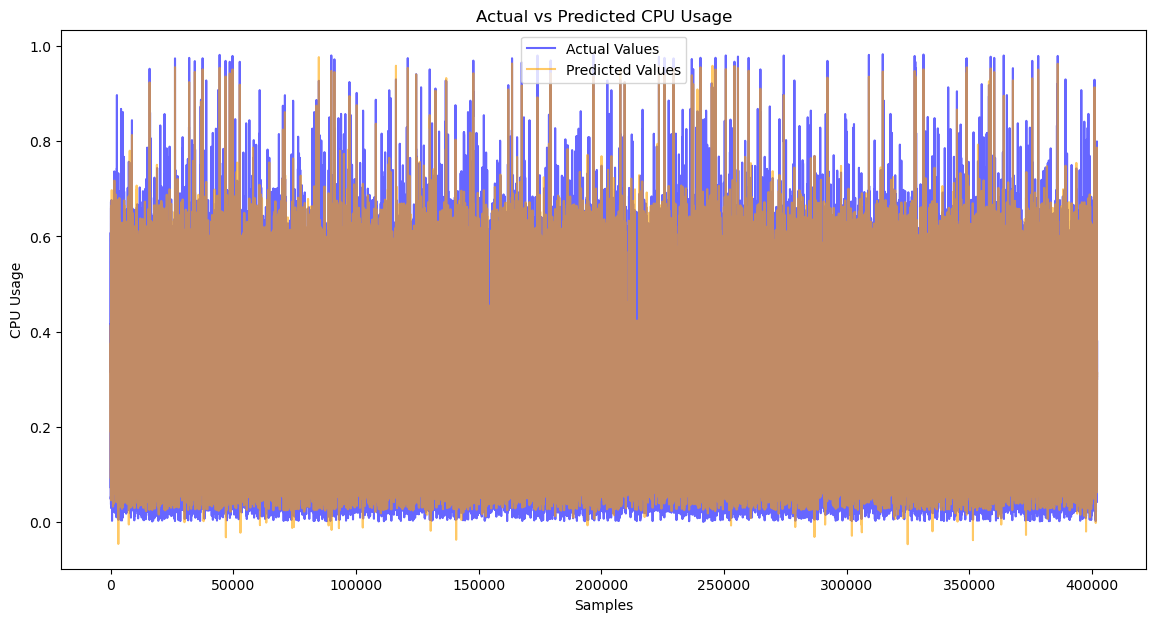

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()  # Separate scaler for the target variable
window_size = 60
prediction_horizon = 10

# Reduce precision and scale features
all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage].astype(np.float32))

# Scale the target (cpu_usage) separately
cpu_data['cpu_usage'] = target_scaler.fit_transform(cpu_data[['cpu_usage']].astype(np.float32))

# Generator function to yield batches
def sequence_generator(group_data, window_size, prediction_horizon, batch_size=128):
    X, y = [], []
    count = 0
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values.astype(np.float32))
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values.astype(np.float32))
        count += 1
        if count >= batch_size:
            yield np.array(X), np.array(y)
            X, y = [], []
            count = 0
    if X and y:
        yield np.array(X), np.array(y)

# Prepare train, val, test splits
X_all, y_all = [], []
for _, group_data in cpu_data.groupby('machine_id'):
    for X_batch, y_batch in sequence_generator(group_data, window_size, prediction_horizon):
        X_all.append(X_batch)
        y_all.append(y_batch)

# Convert list of batches to array and reduce precision
X_all = np.concatenate(X_all, axis=0).astype(np.float32)
y_all = np.concatenate(y_all, axis=0).astype(np.float32)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Define paths to the models
model_paths = [
    'best_model_2.keras',
    'best_model.keras',
    'best_model_idea.keras',
    'best_model_colab.keras'
]

# Create a dictionary to store model performances
model_performance = {}

# Loop over each model
for i, model_path in enumerate(model_paths):
    # Load the model
    model = load_model(model_path)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values if necessary
    y_pred_unscaled = target_scaler.inverse_transform(y_pred)
    y_test_unscaled = target_scaler.inverse_transform(y_test)
    
    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
    rmse = np.sqrt(mse)
    
    # Store the results
    model_performance[f'model_{i+1}'] = {'MSE': mse, 'RMSE': rmse, 'Name': model_path, 'predictions': y_pred.flatten() ,'true': y_test.flatten()}

    # Print or log performance for this model
    print(f"Model {i+1} - RMSE: {rmse}, MSE: {mse}")

# Optionally, you can find the best performing model
best_model = min(model_performance, key=lambda x: model_performance[x]['MSE'])
print(f"Best performing model: {model_performance[best_model]['Name']} with MSE: {model_performance[best_model]['MSE']}")
plt.figure(figsize=(14, 7))
plt.plot(model_performance[best_model]['true'], label='Actual Values', color='blue', alpha=0.6)
plt.plot(model_performance[best_model]['predictions'], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

Model is not converging.  Current: 43339268.856989086 is not greater than 47554015.22653167. Delta is -4214746.369542584


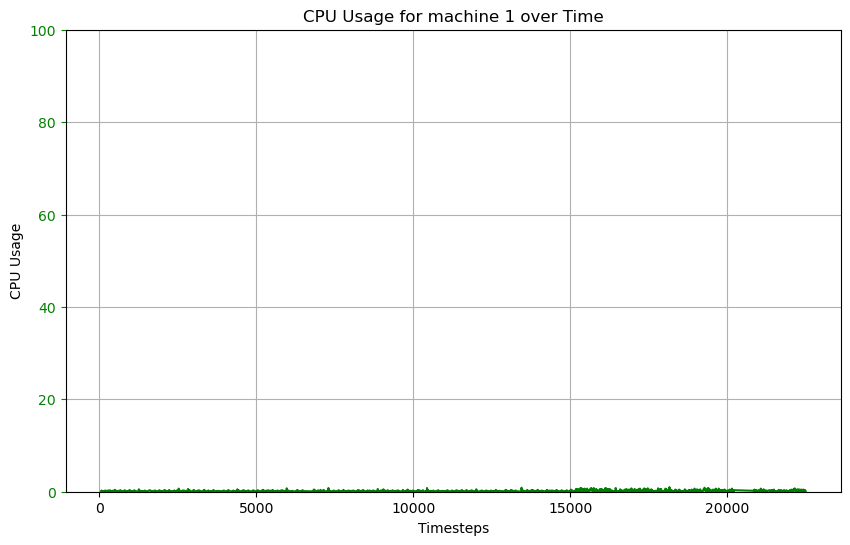

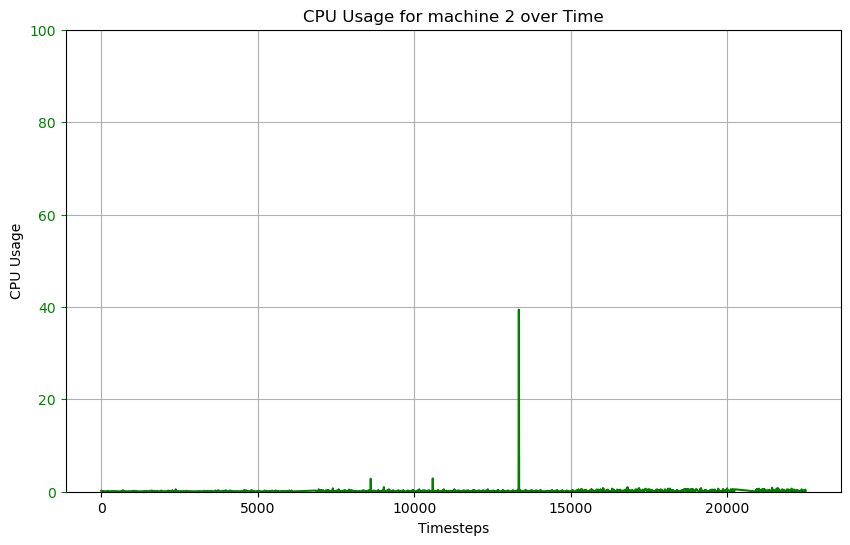

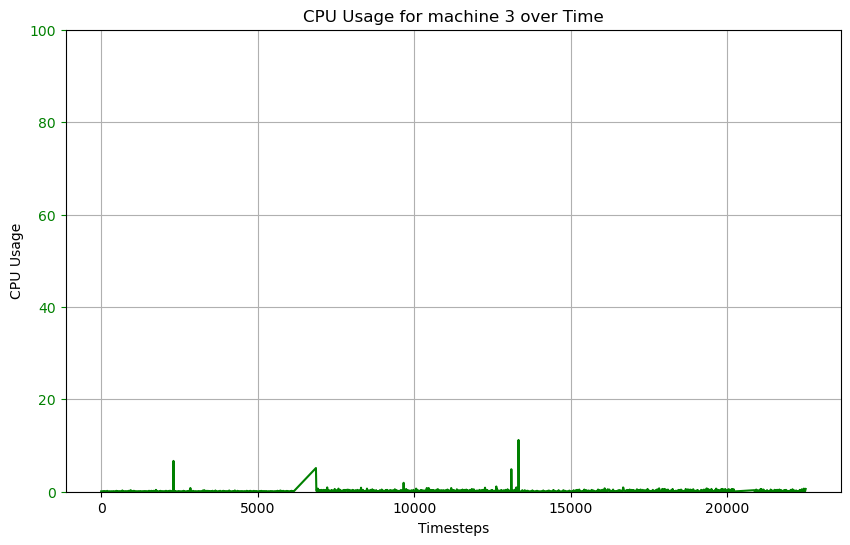

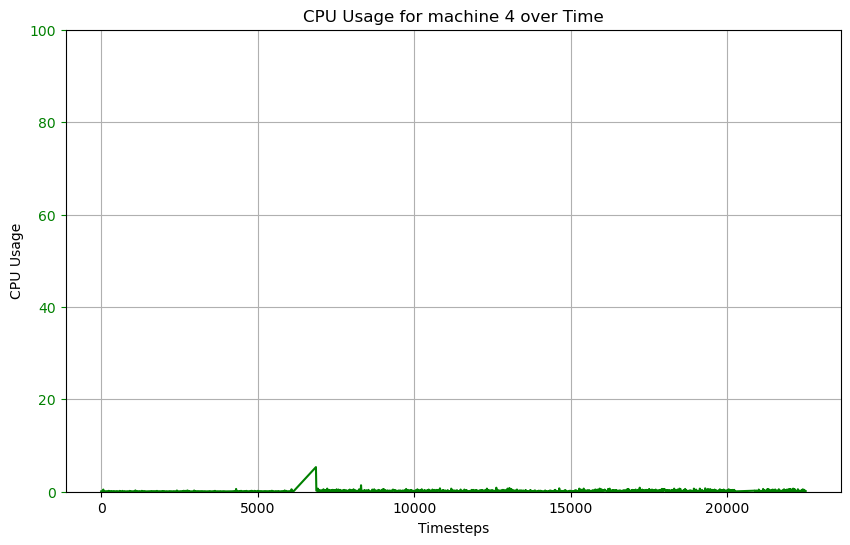

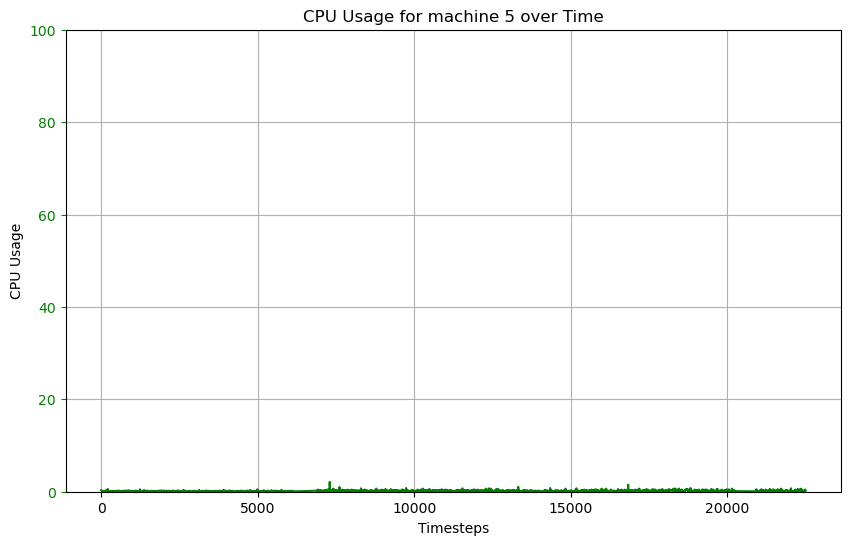

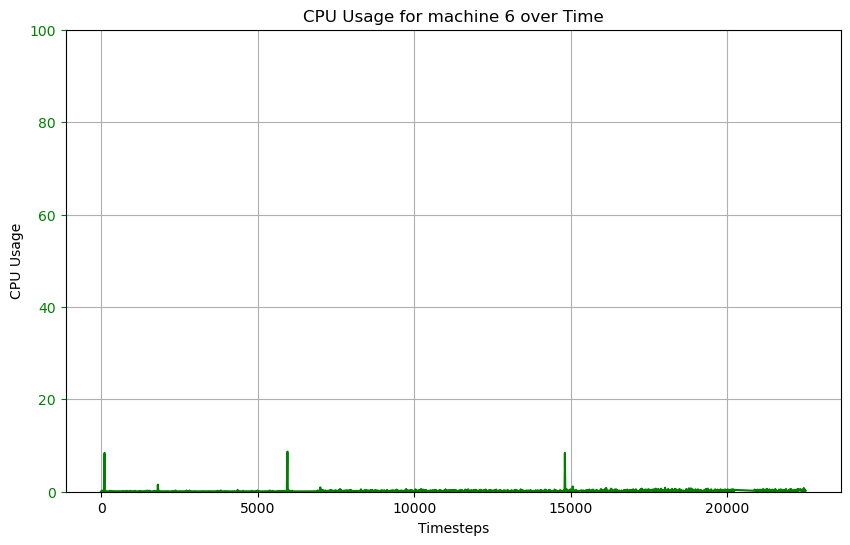

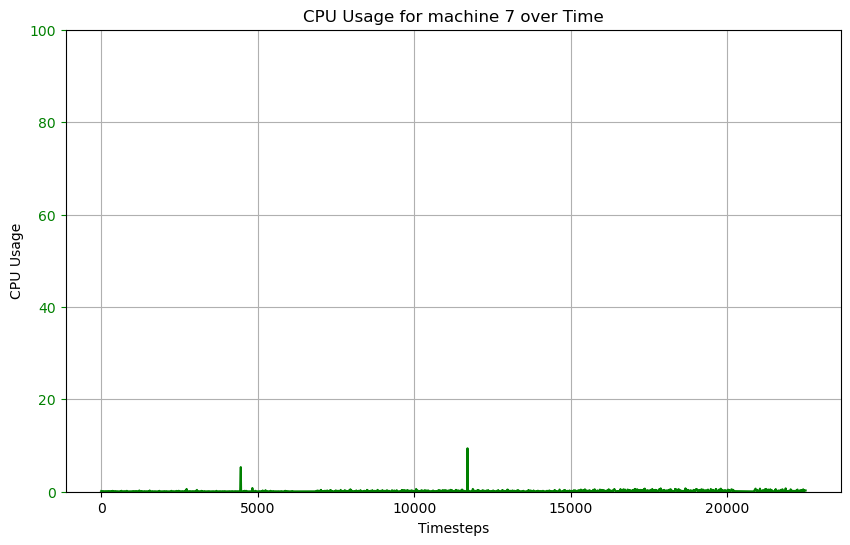

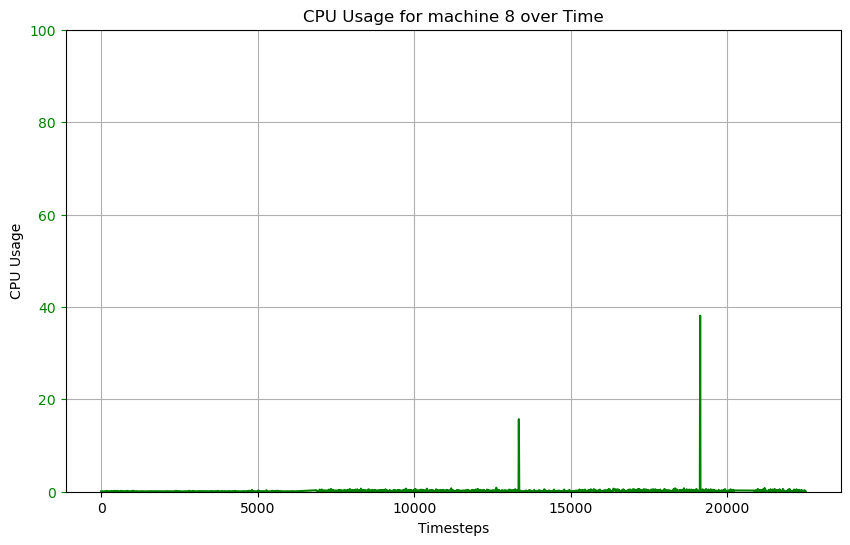

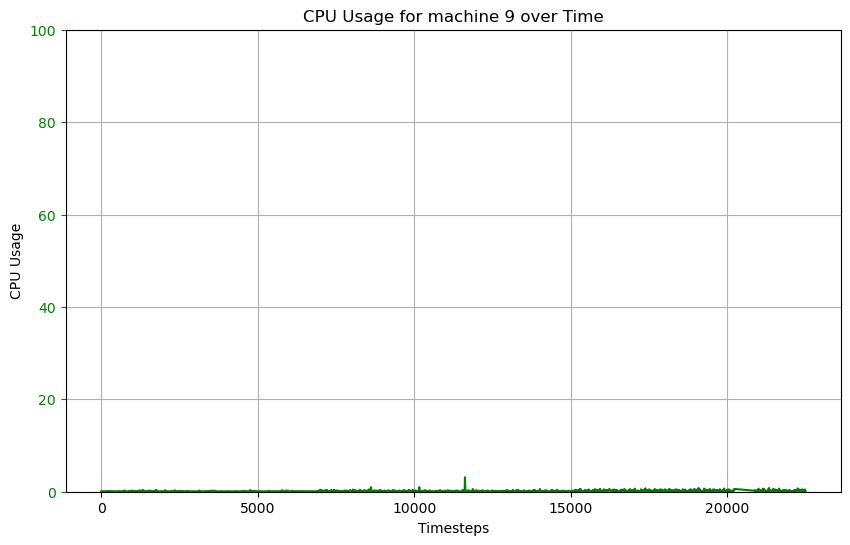

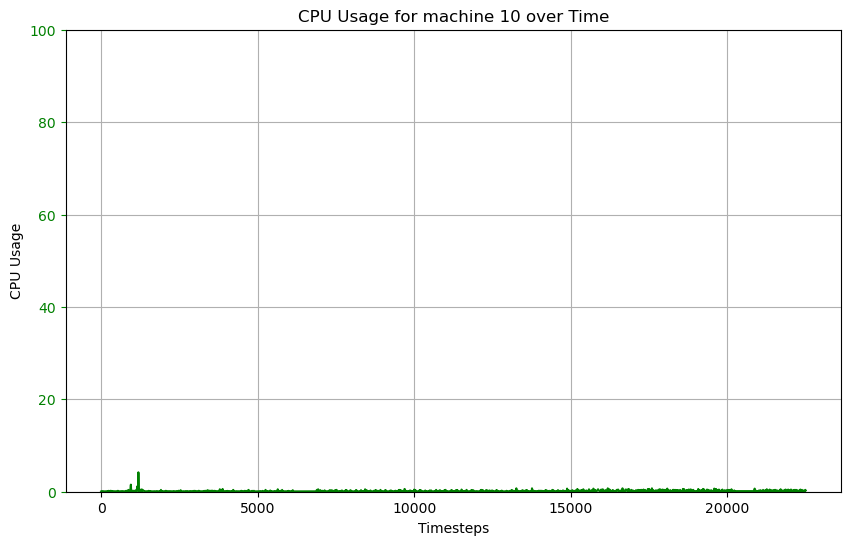

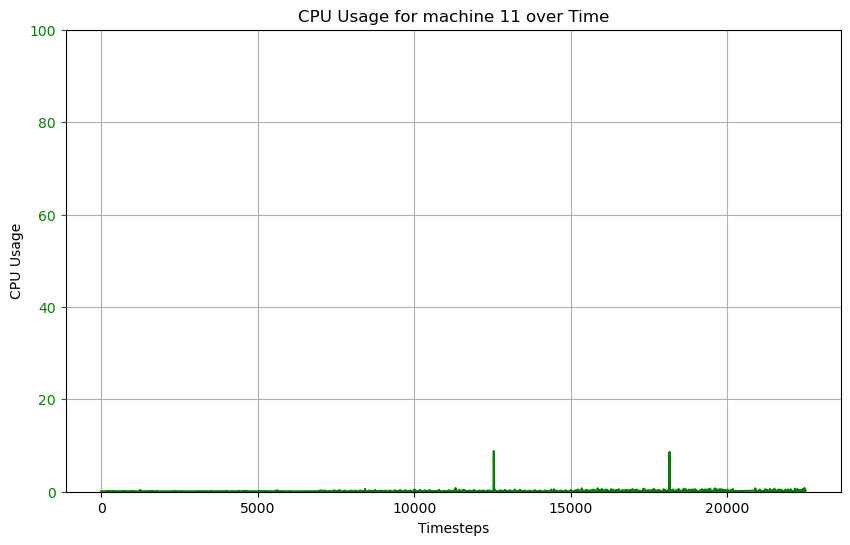

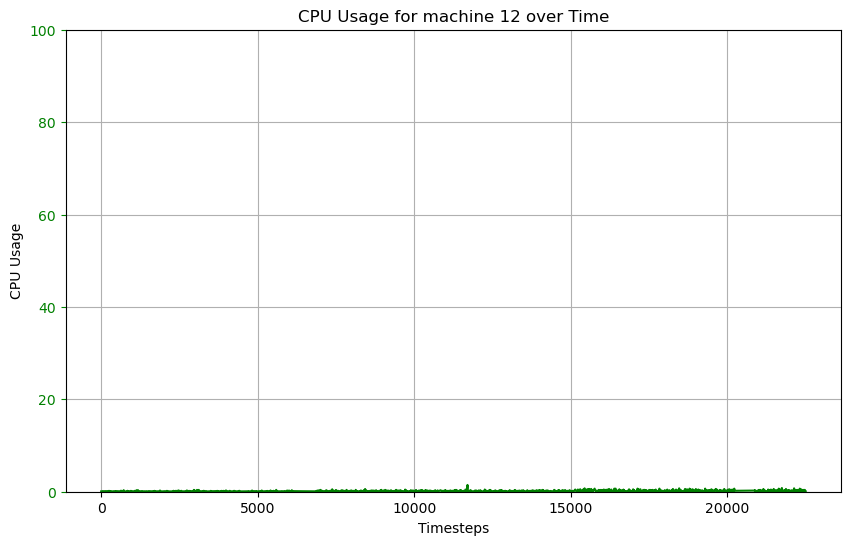

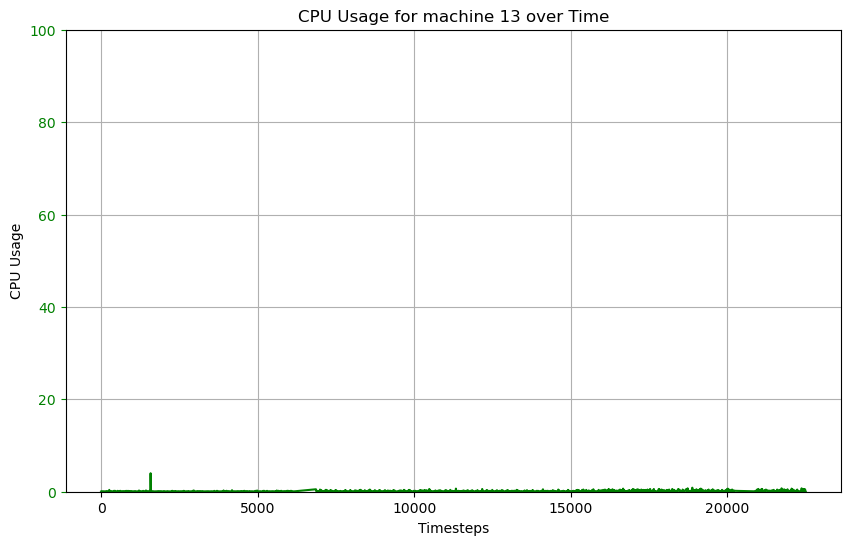

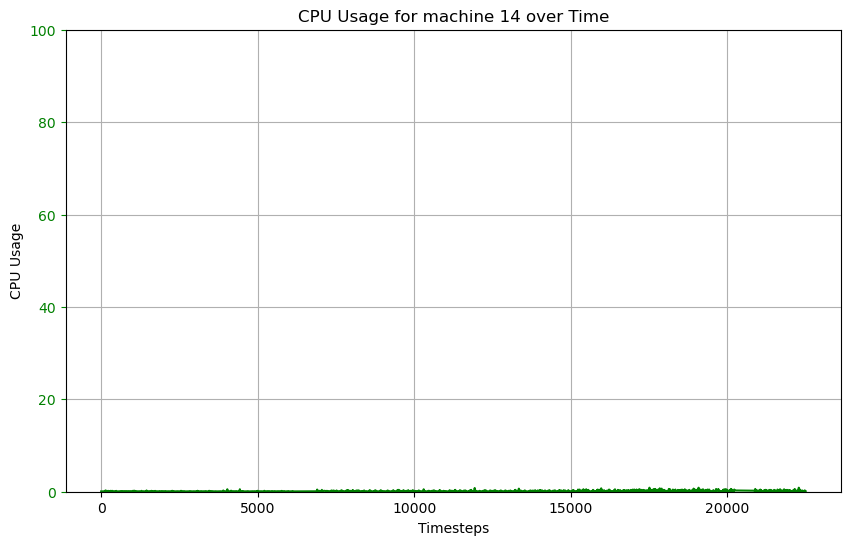

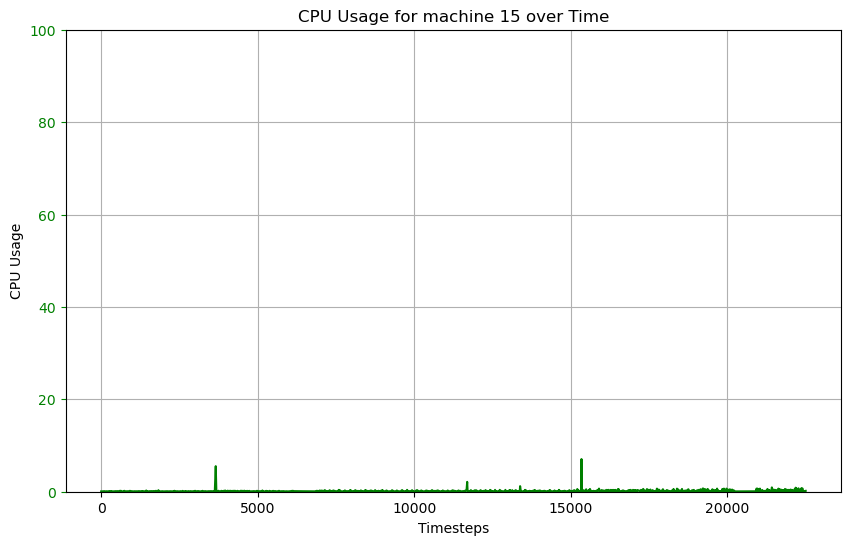

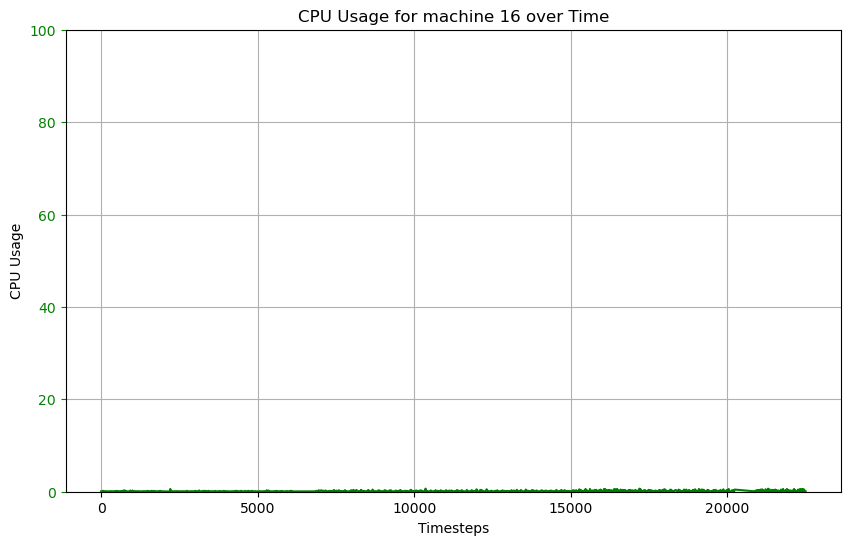

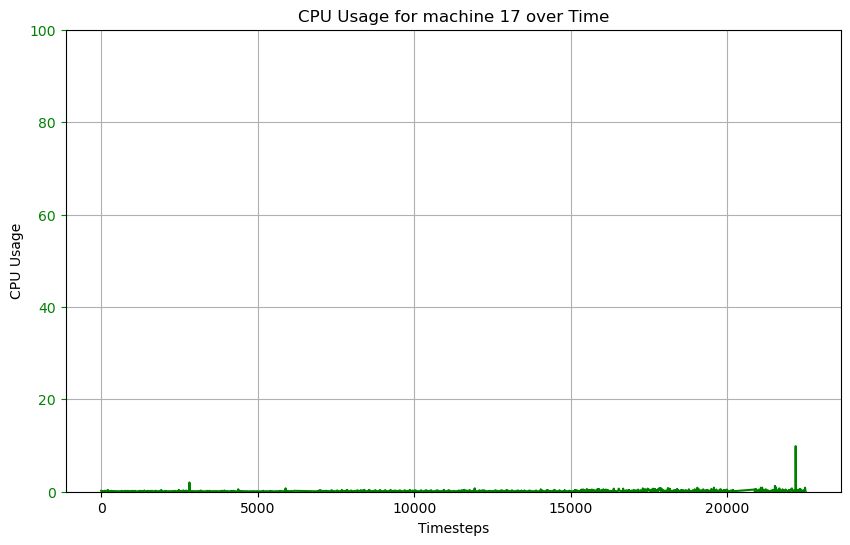

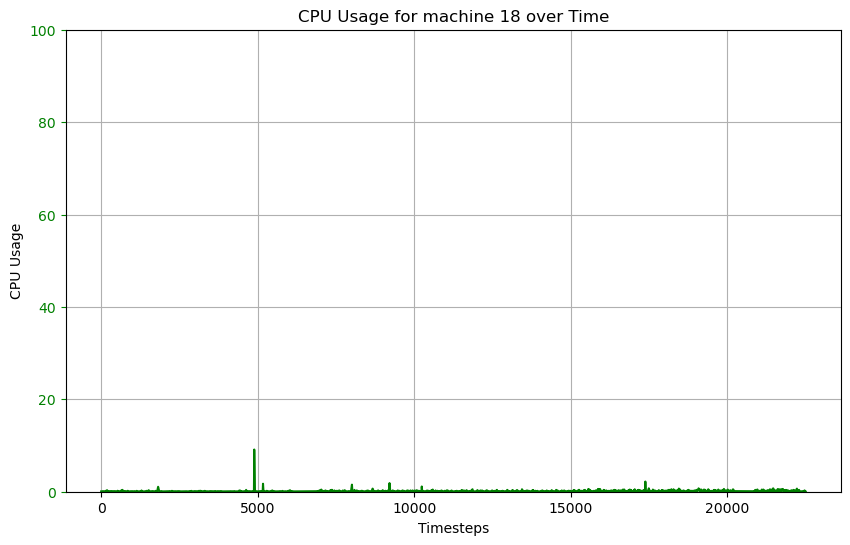

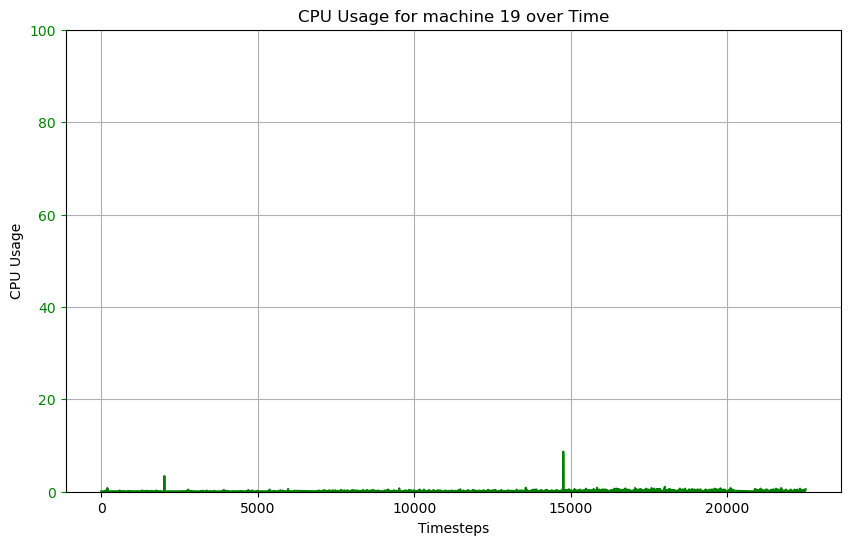

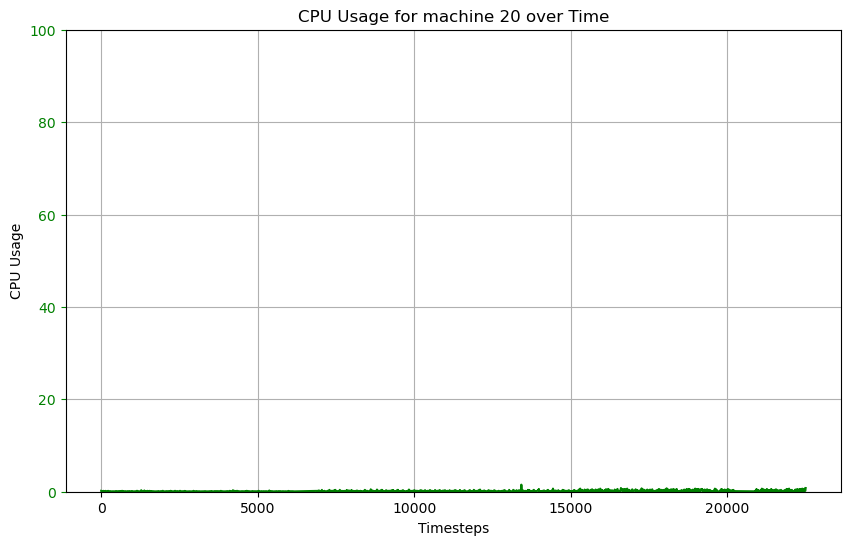

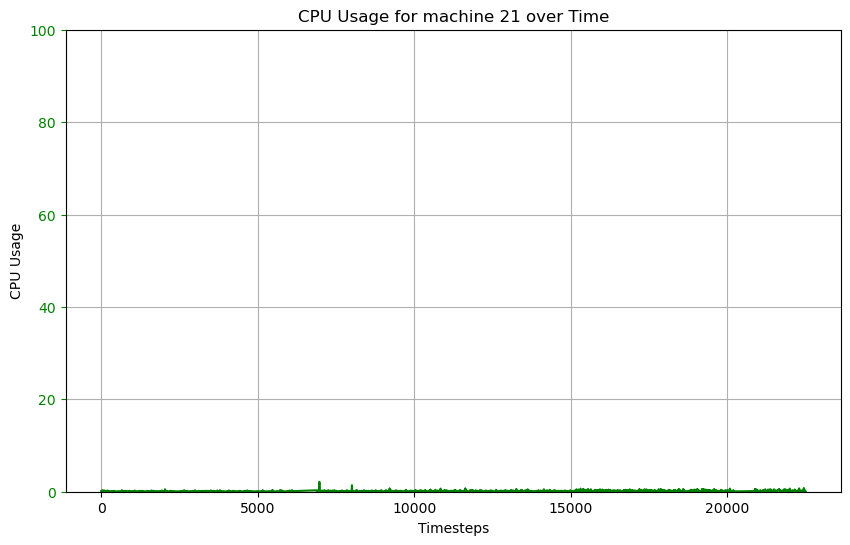

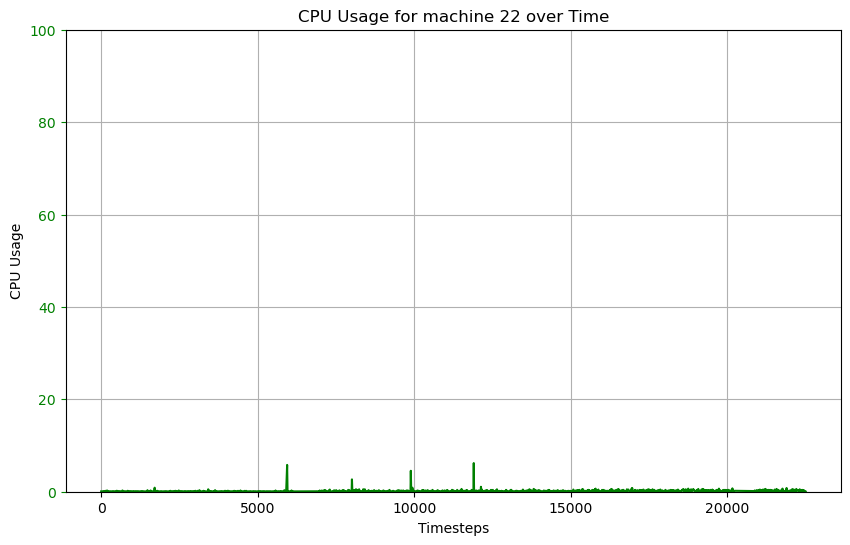

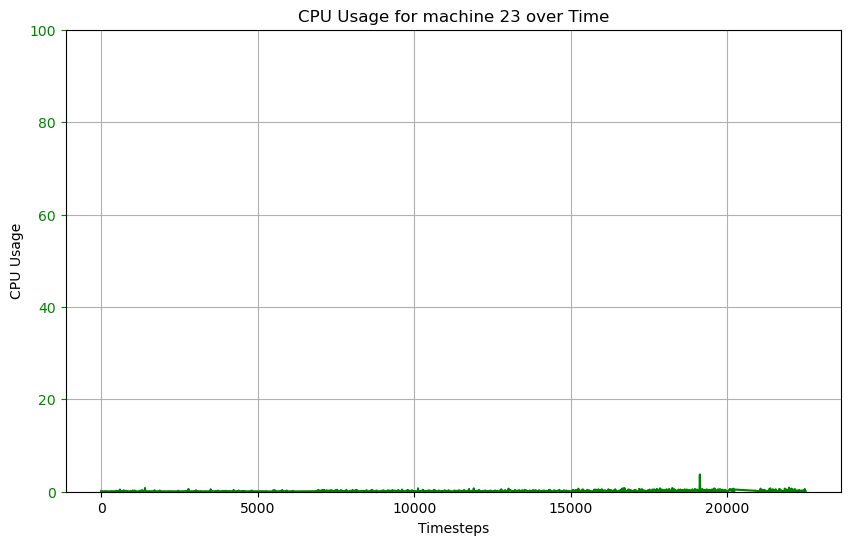

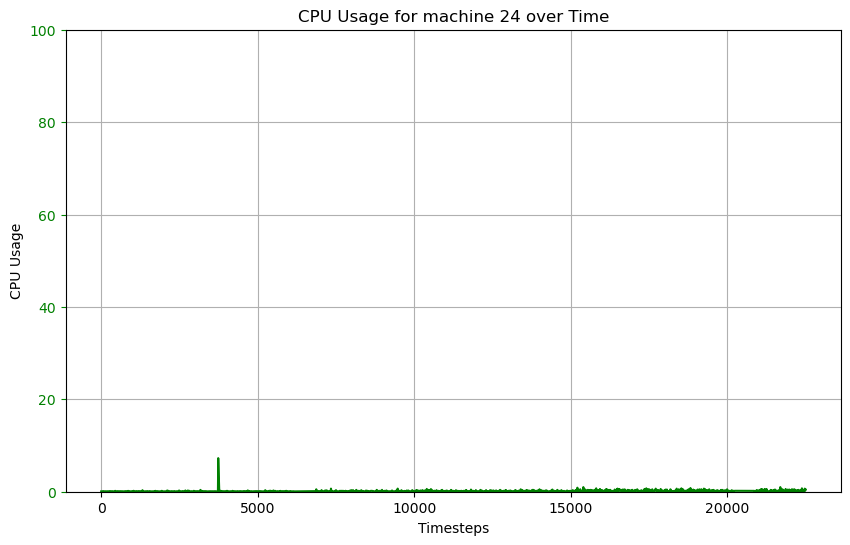

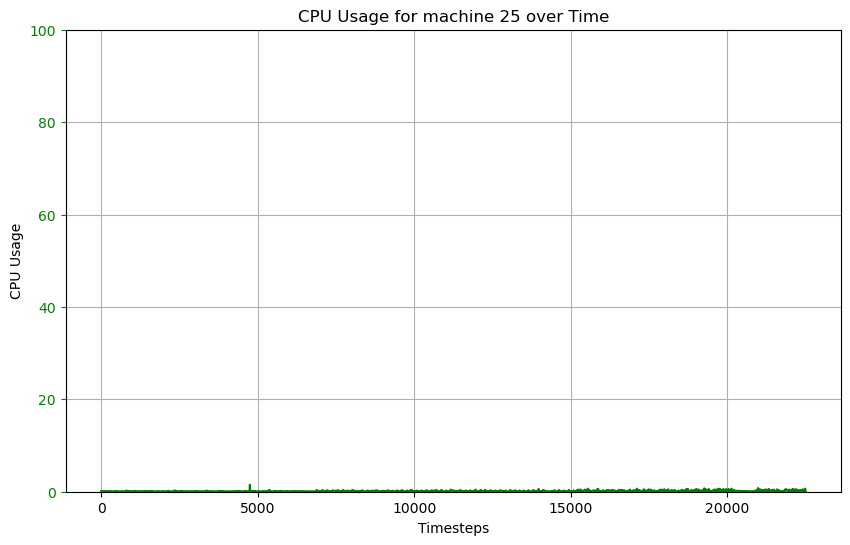

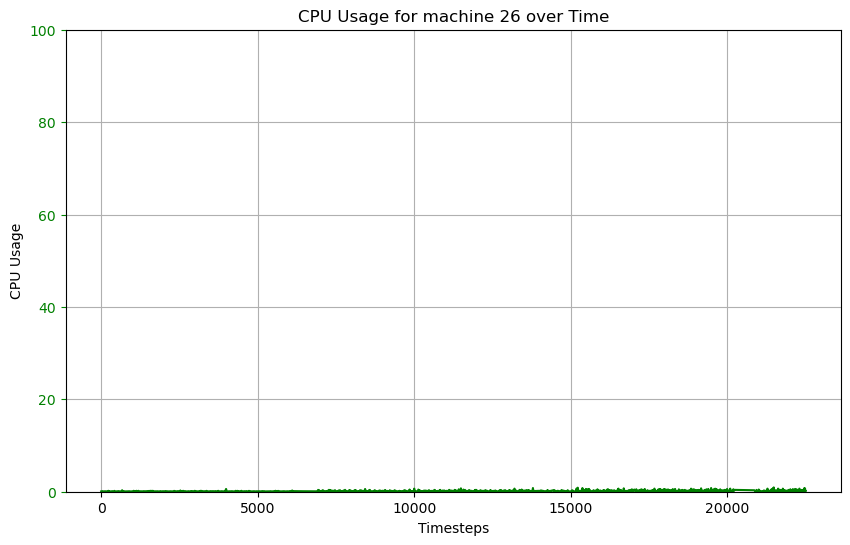

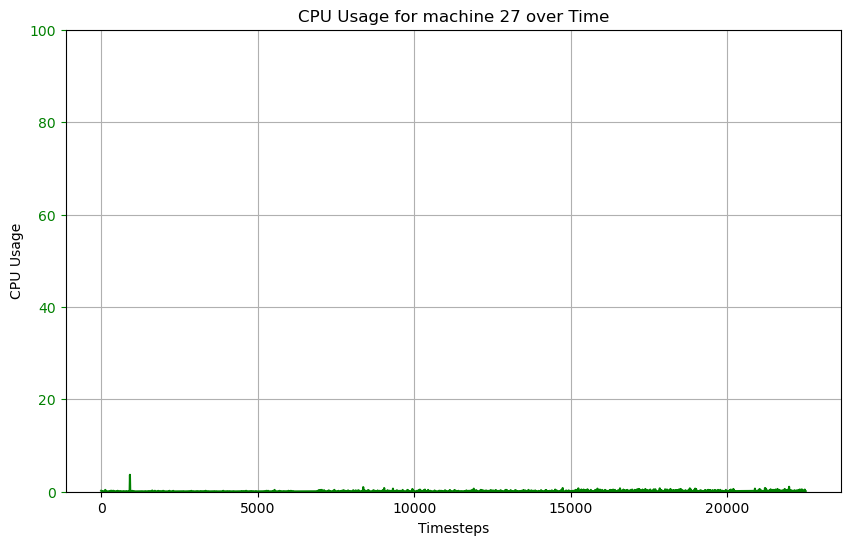

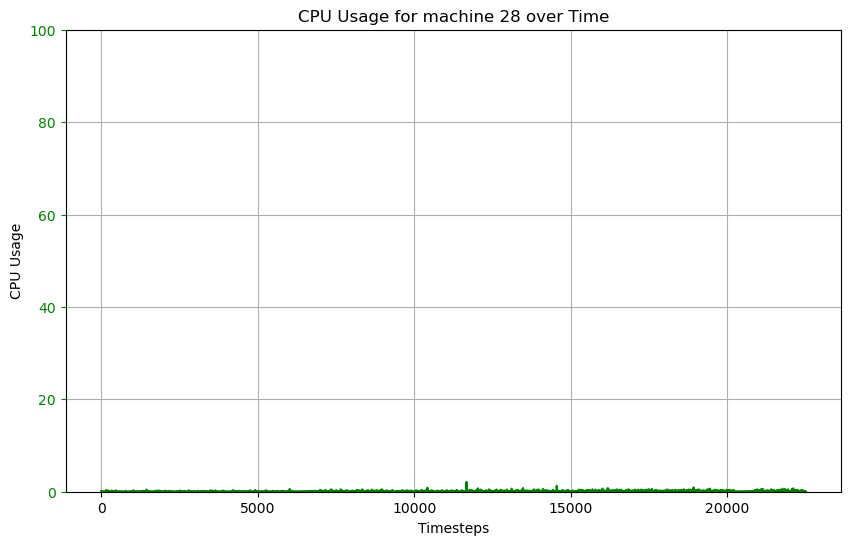

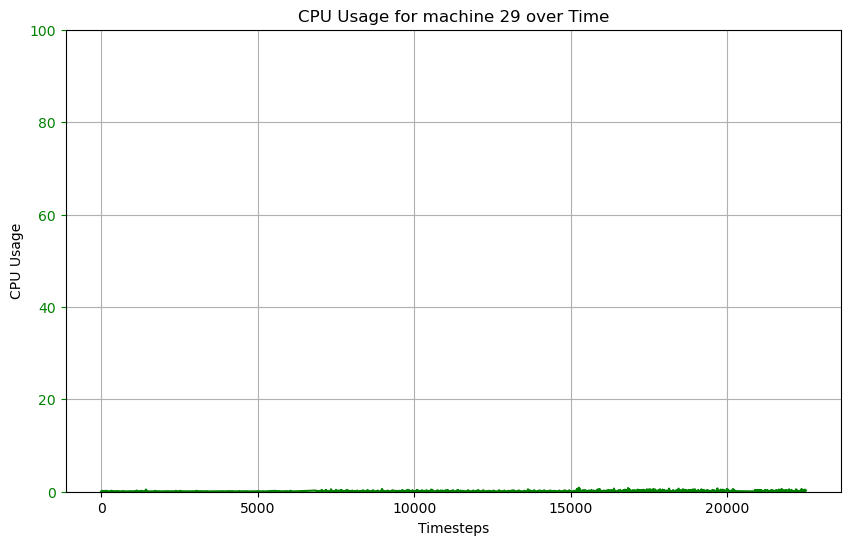

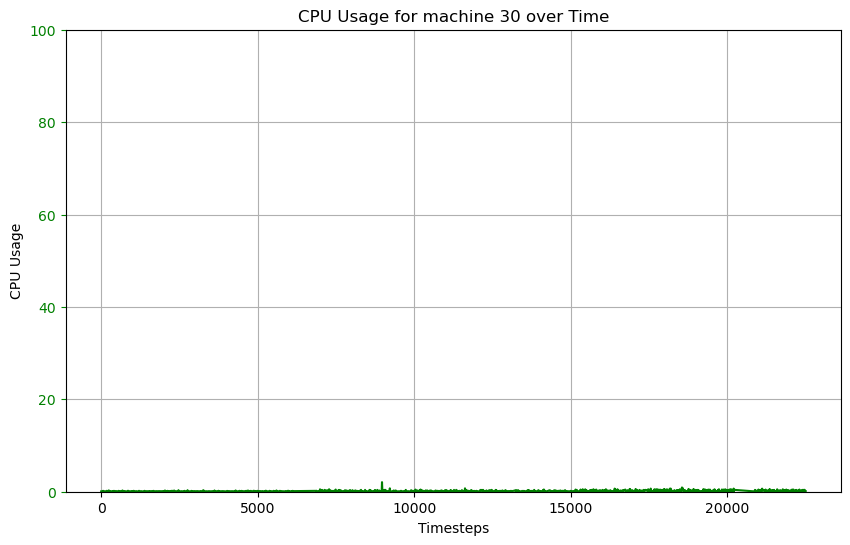

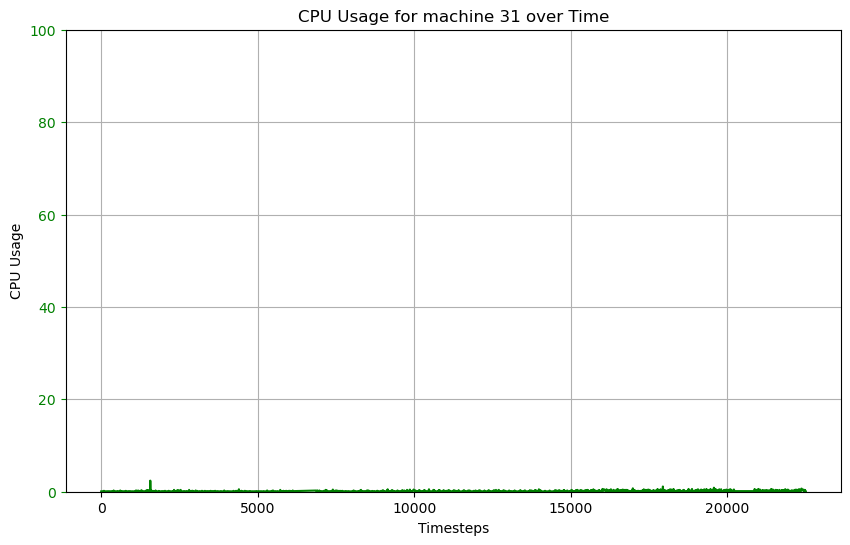

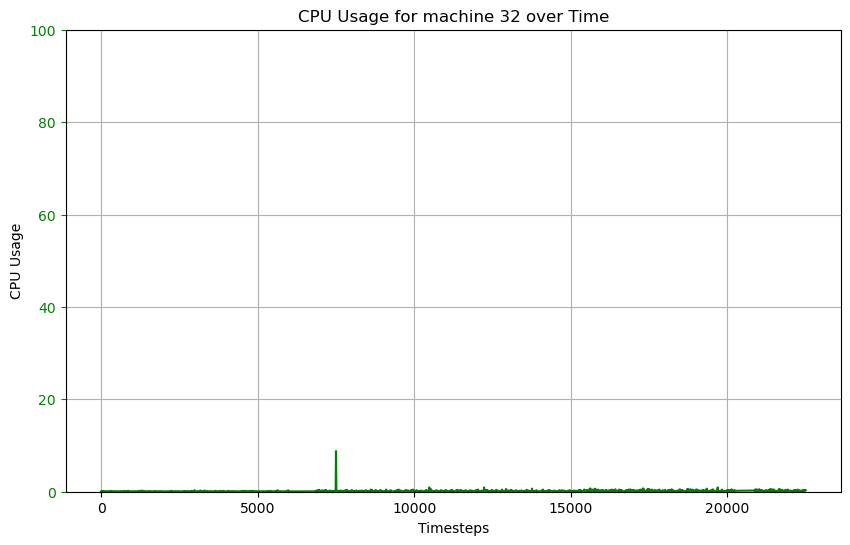

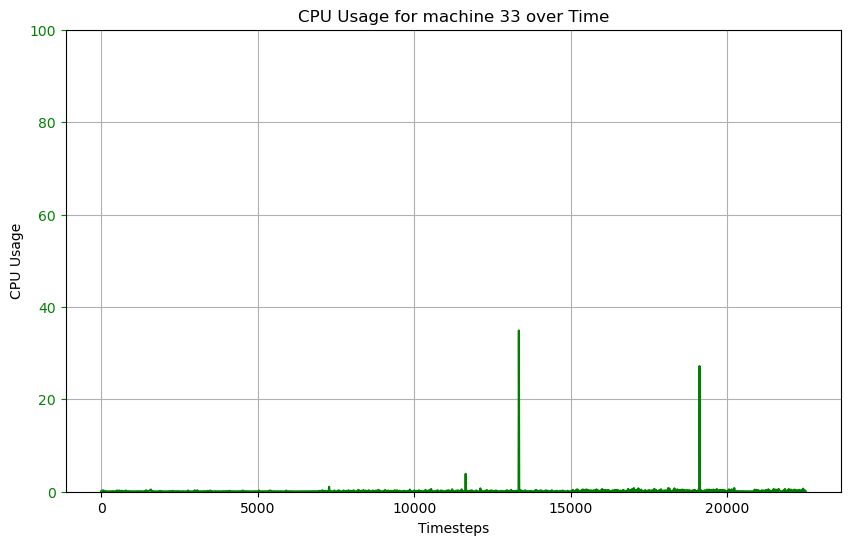

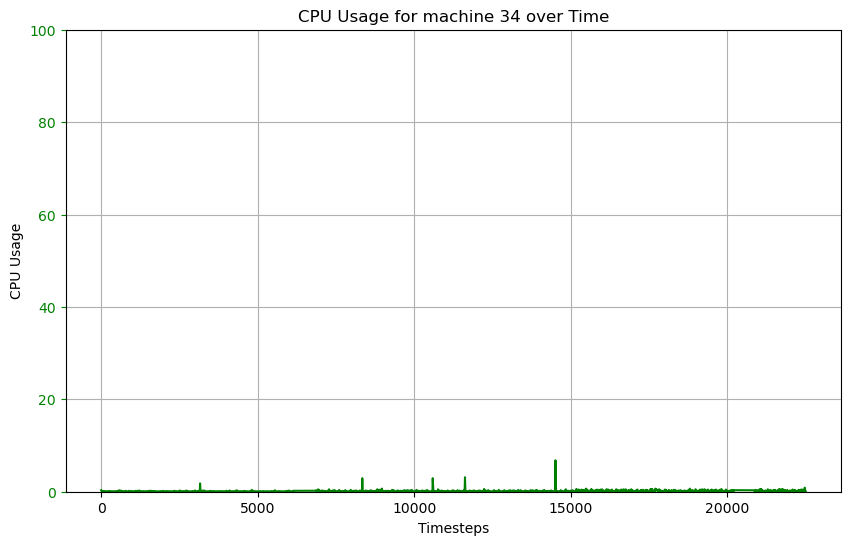

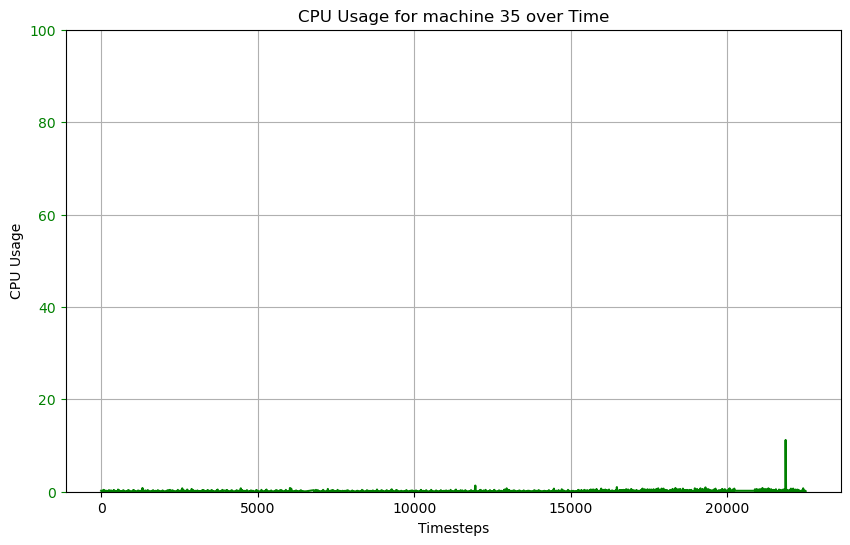

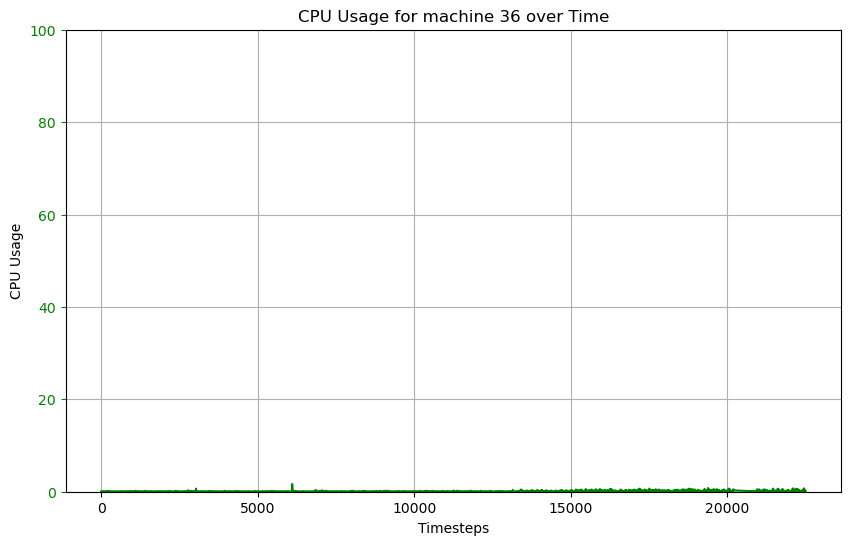

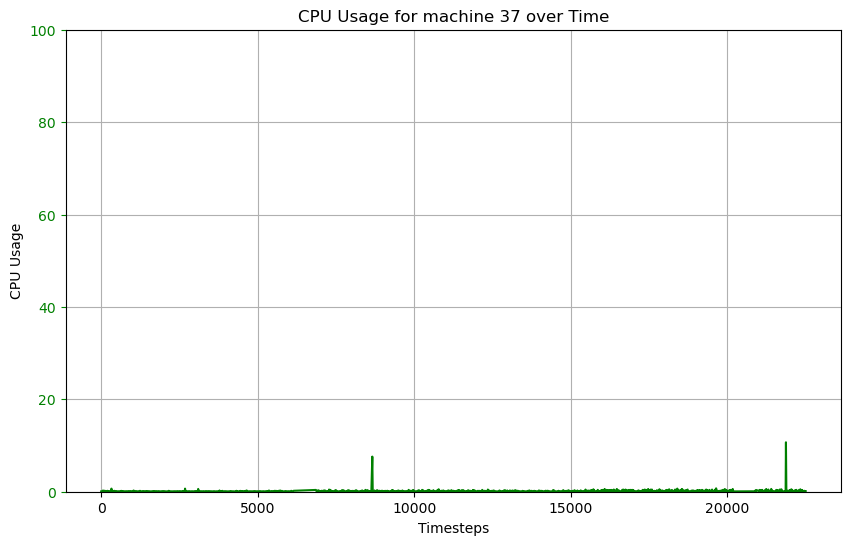

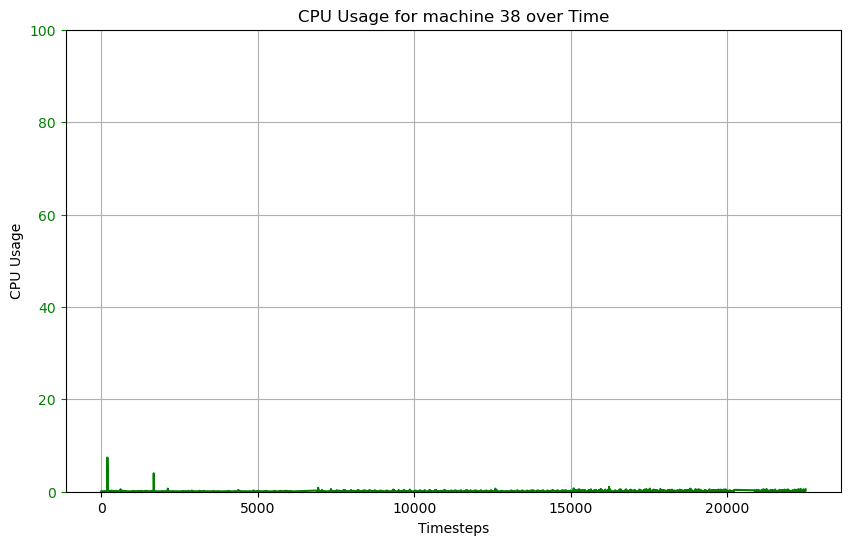

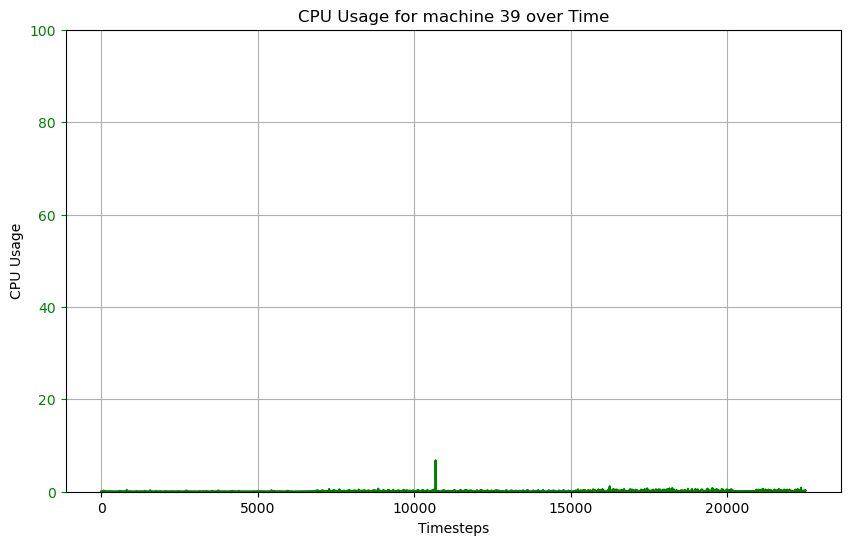

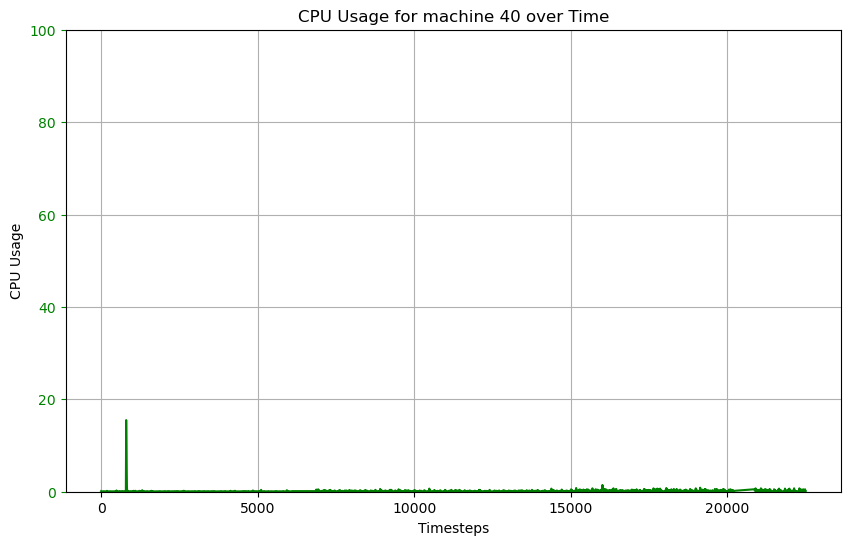

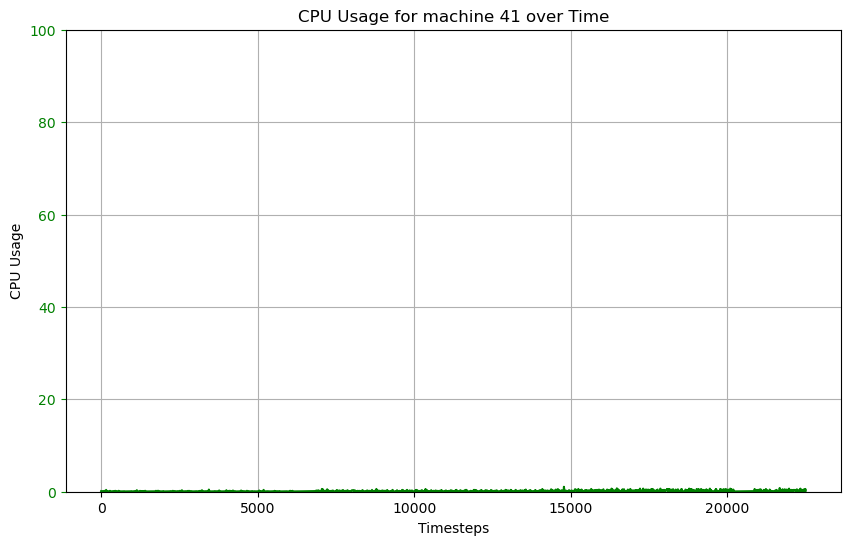

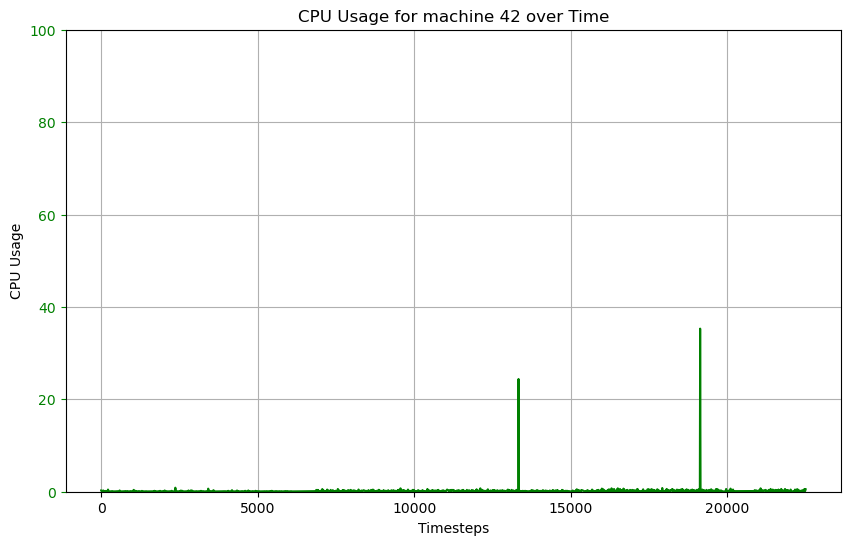

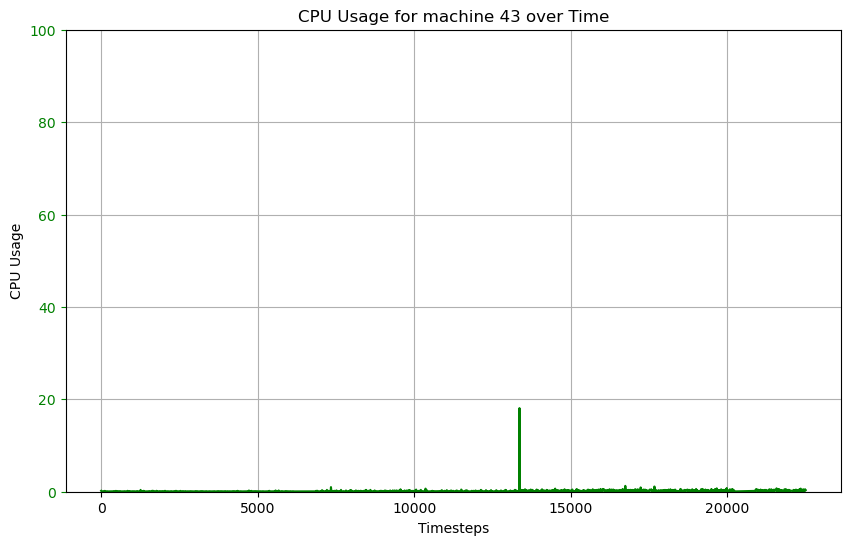

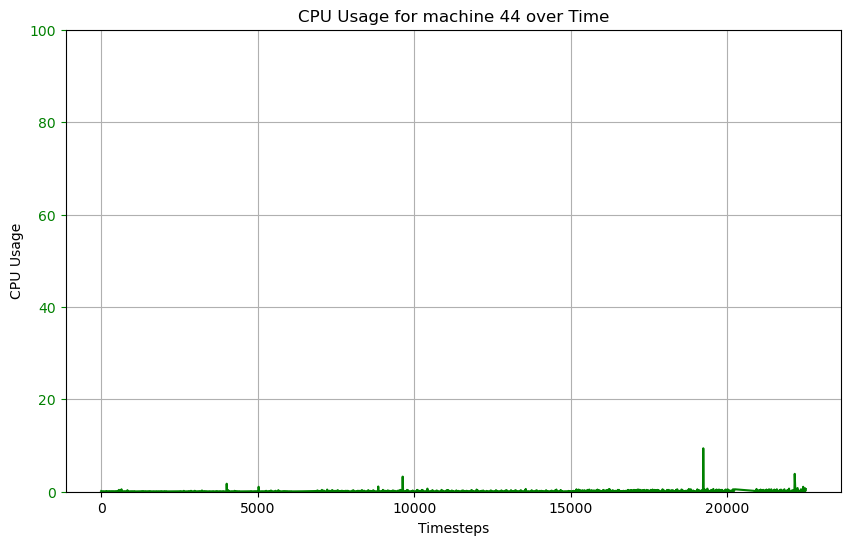

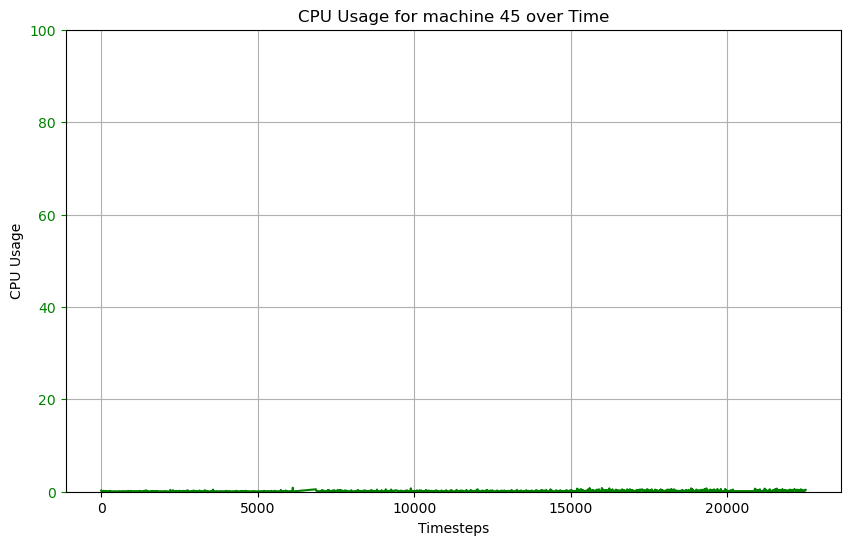

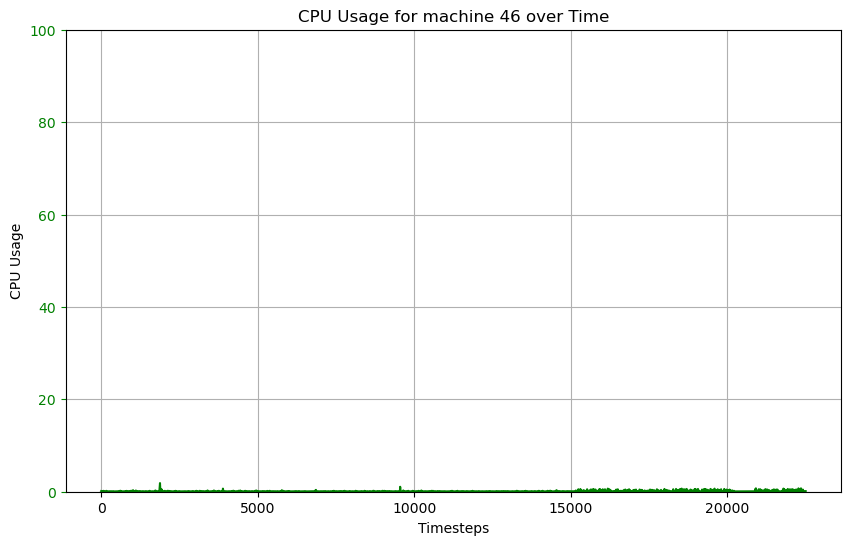

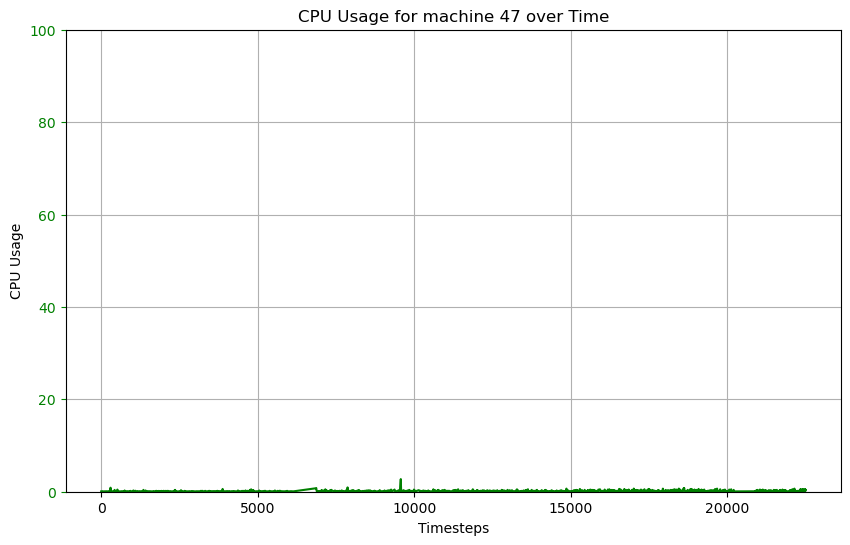

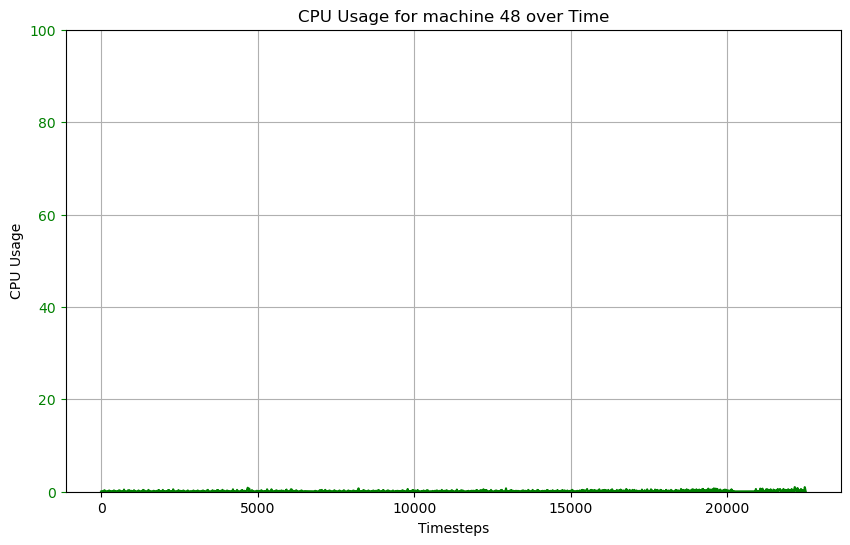

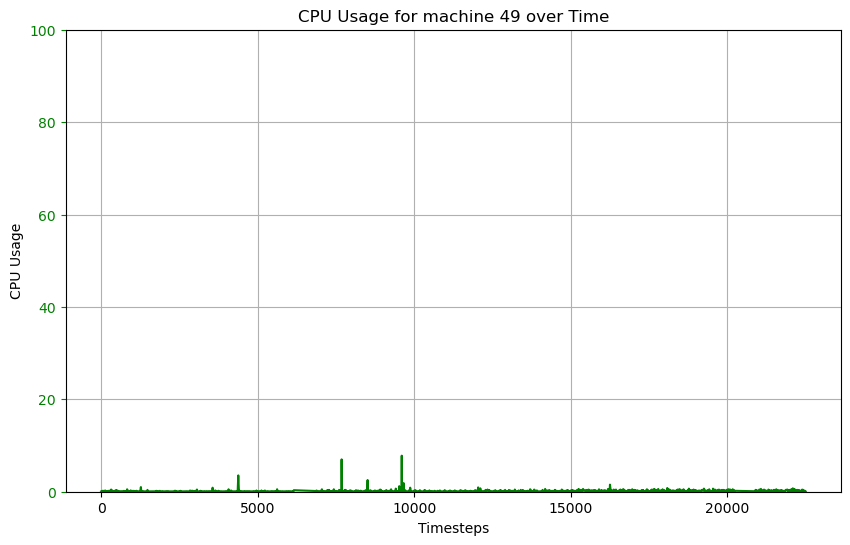

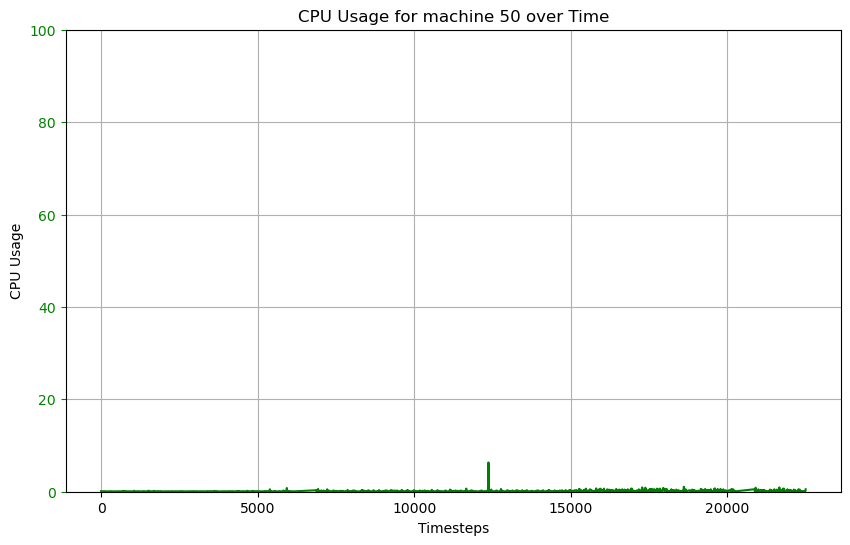

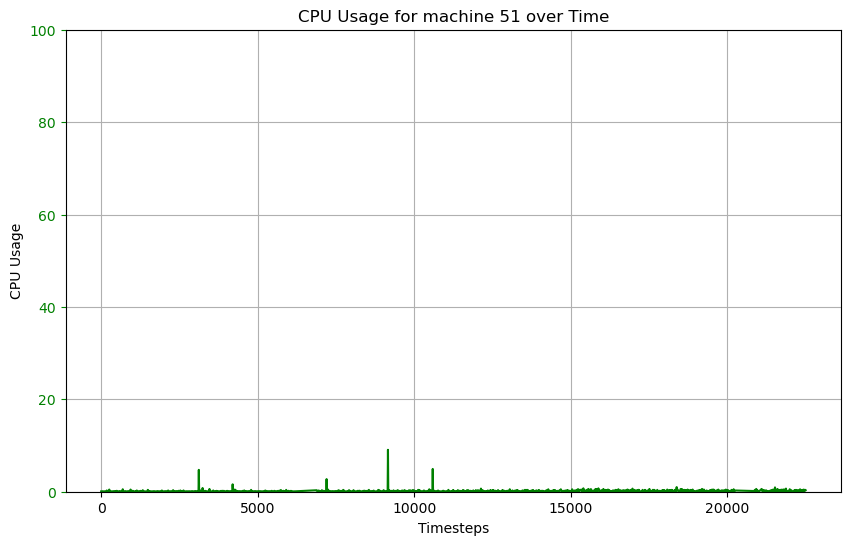

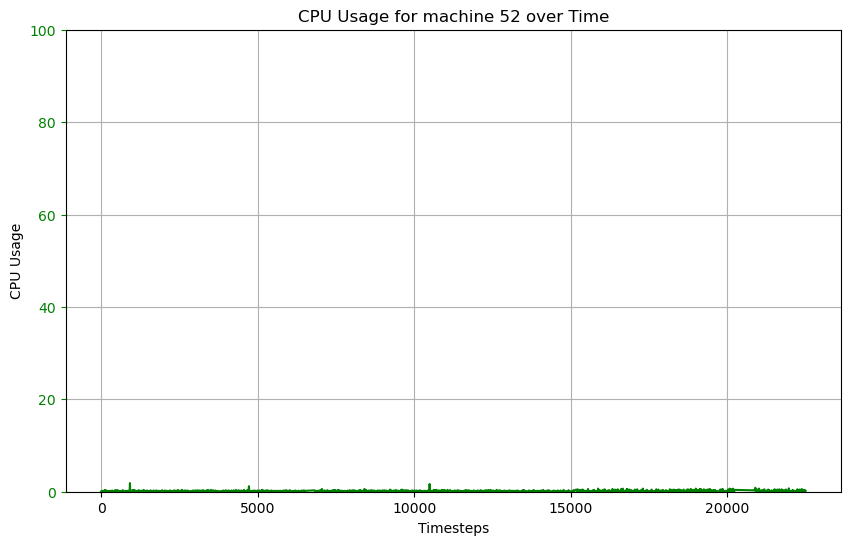

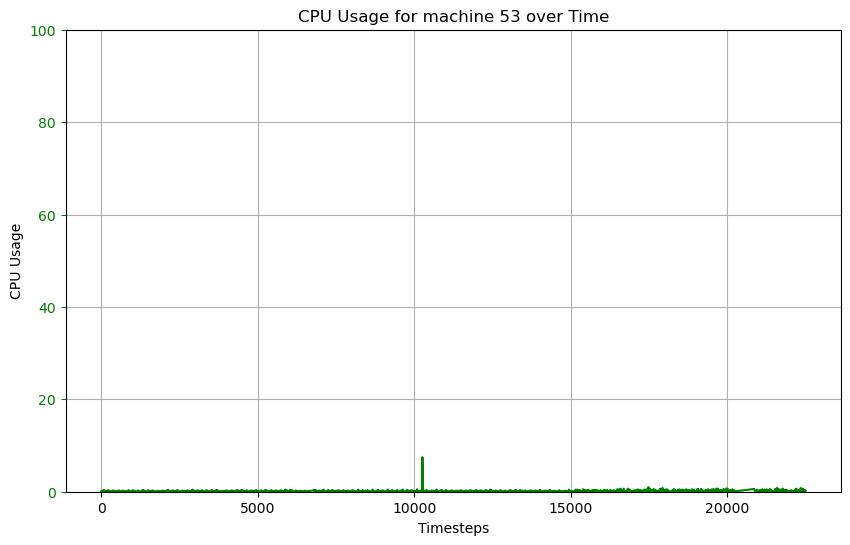

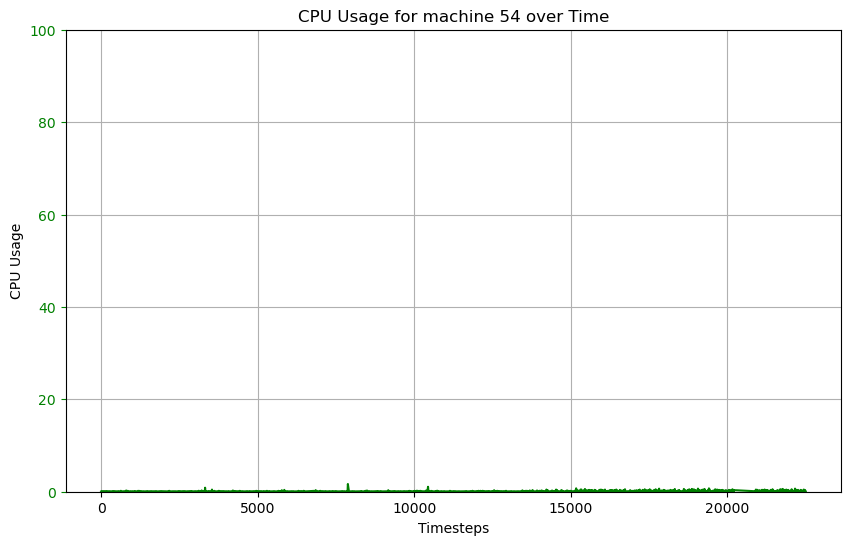

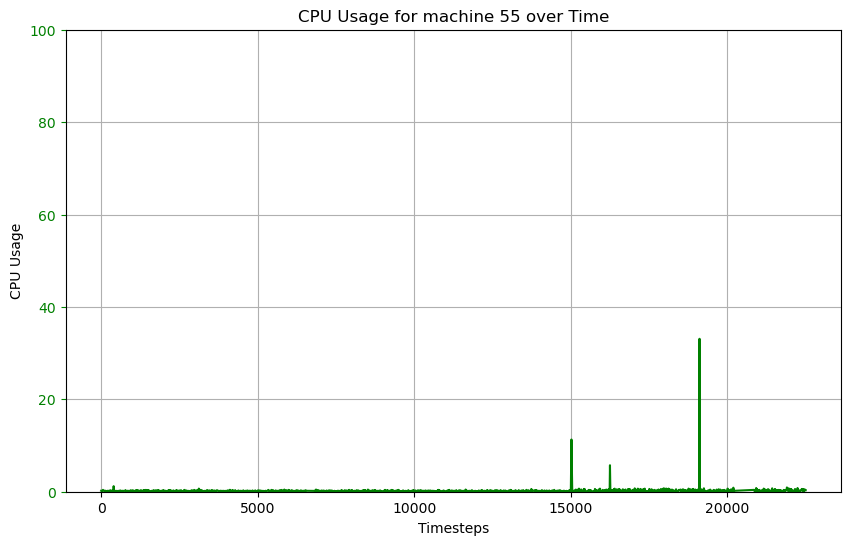

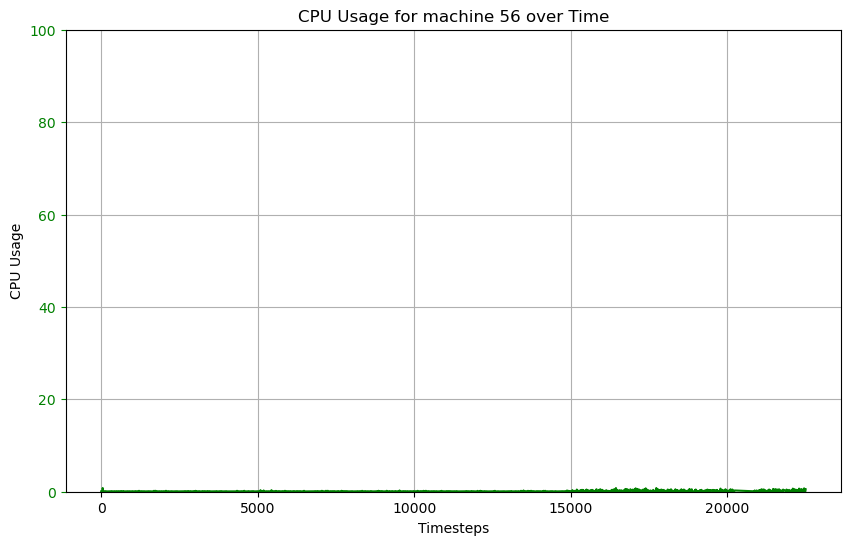

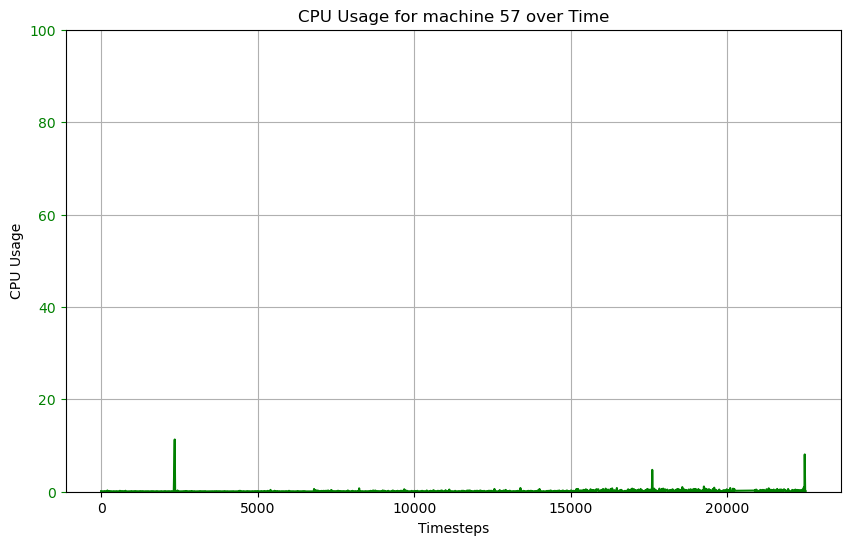

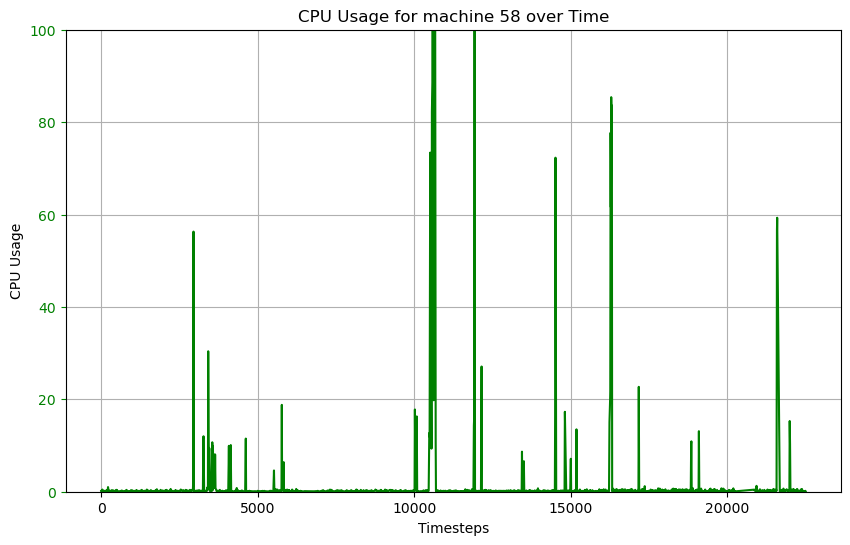

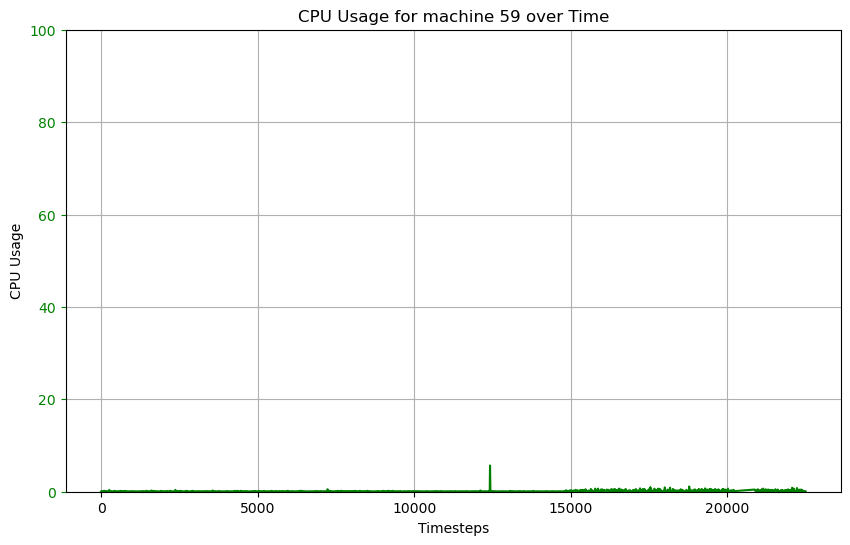

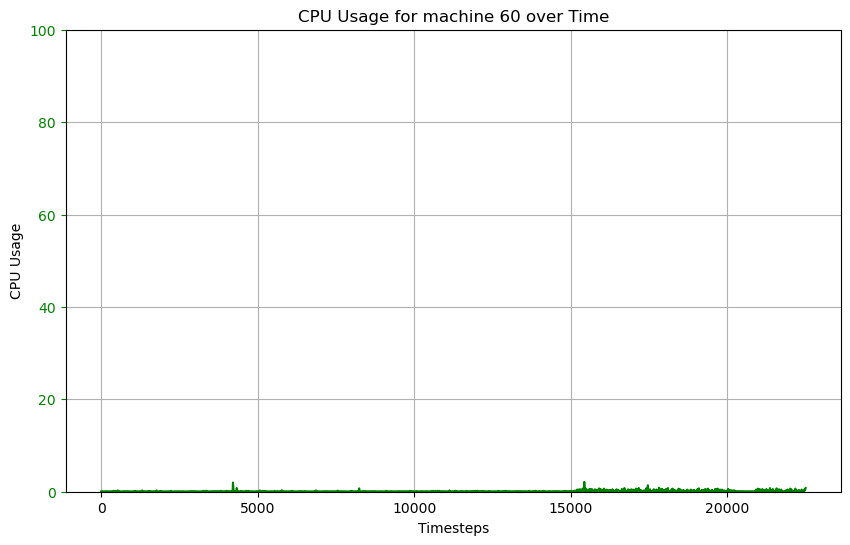

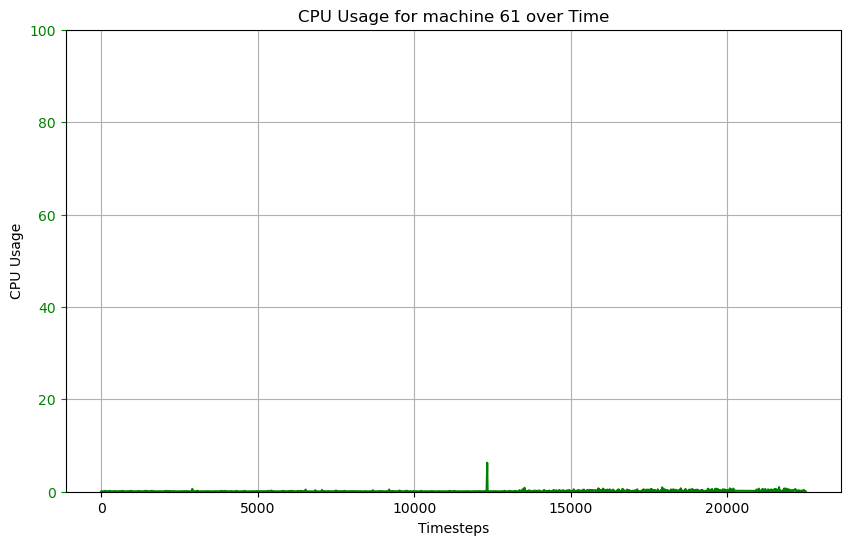

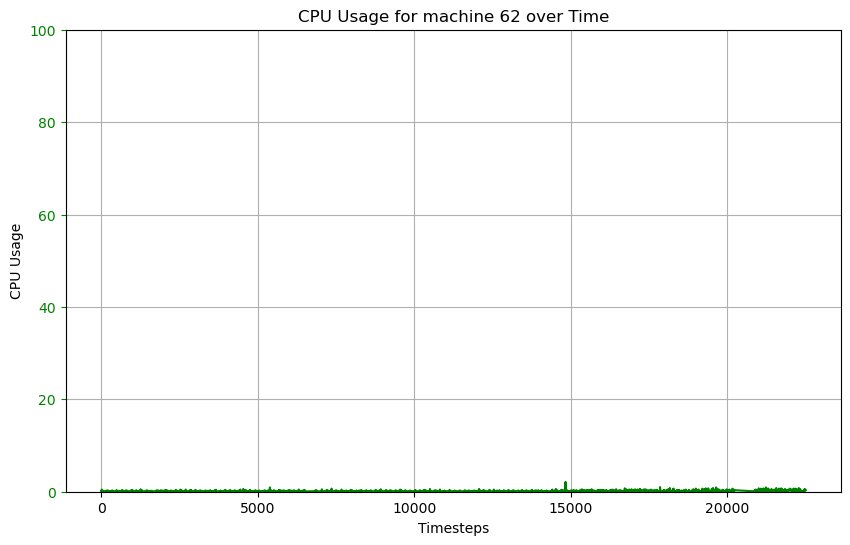

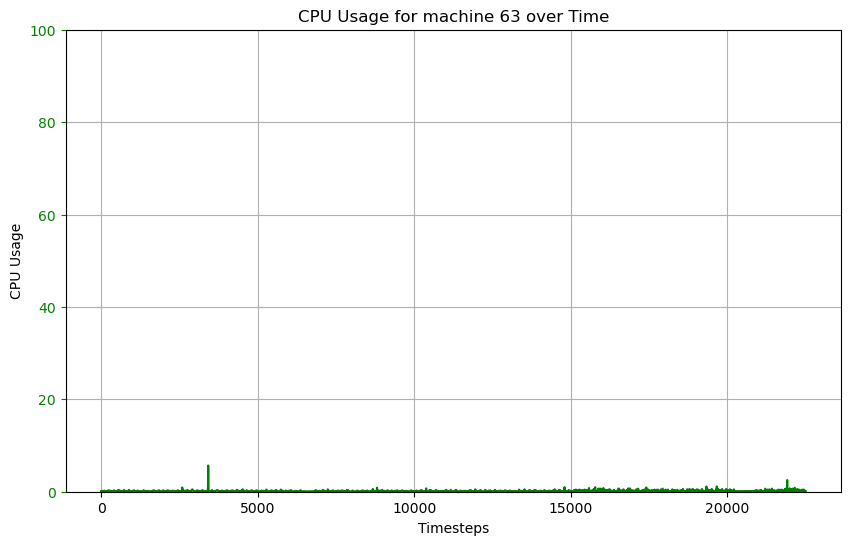

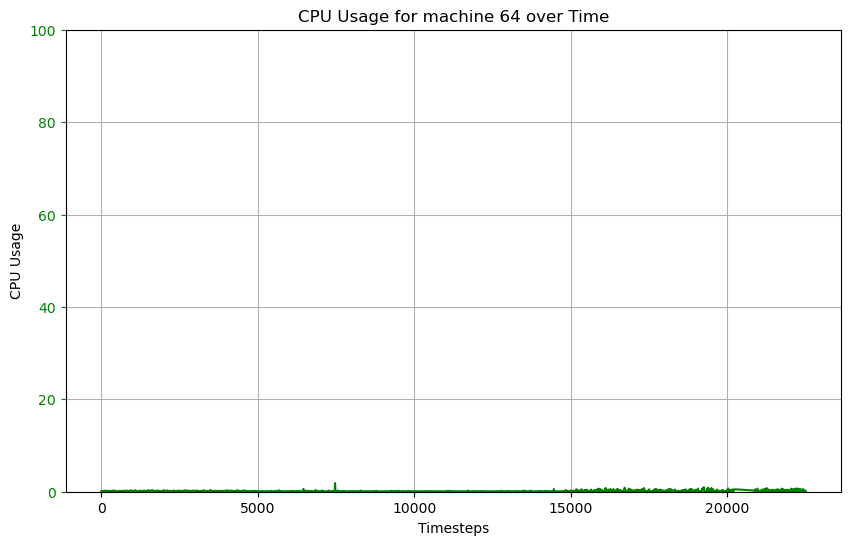

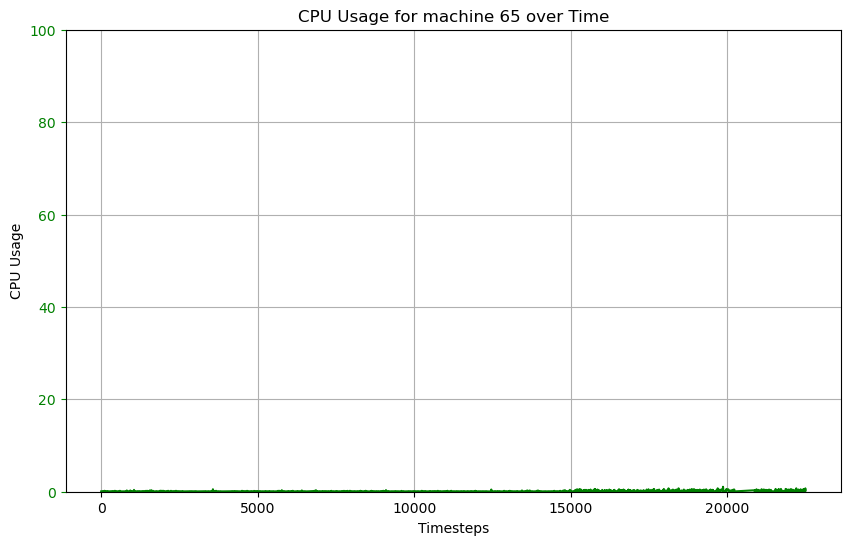

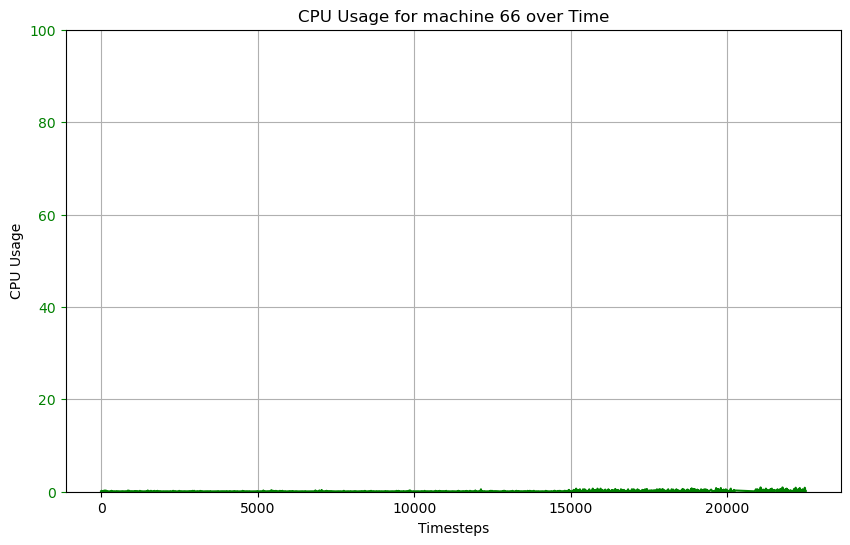

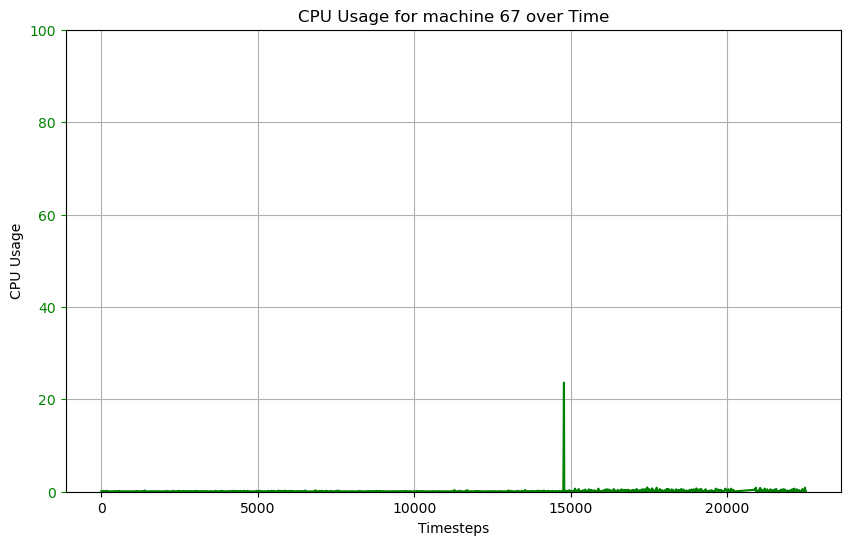

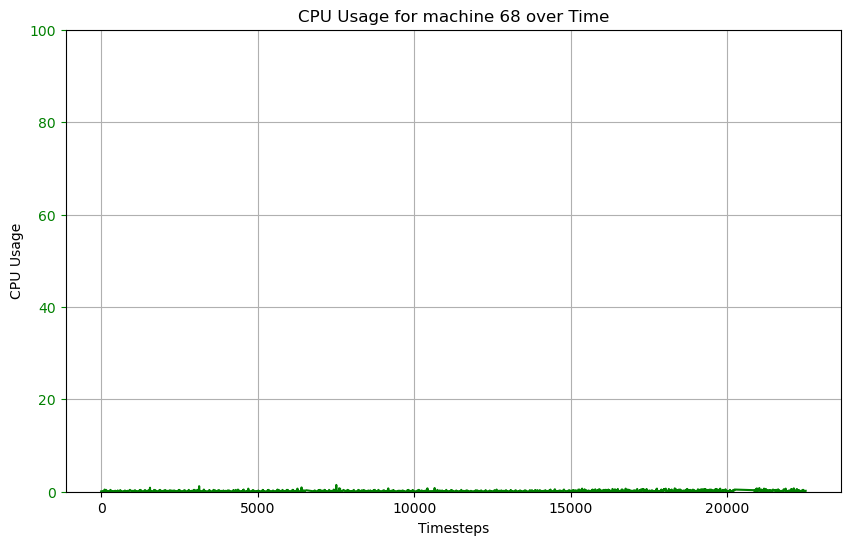

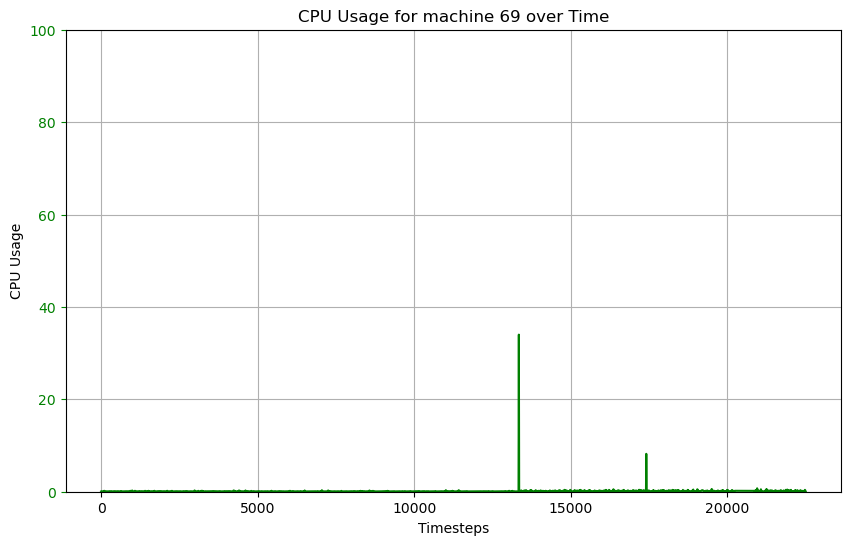

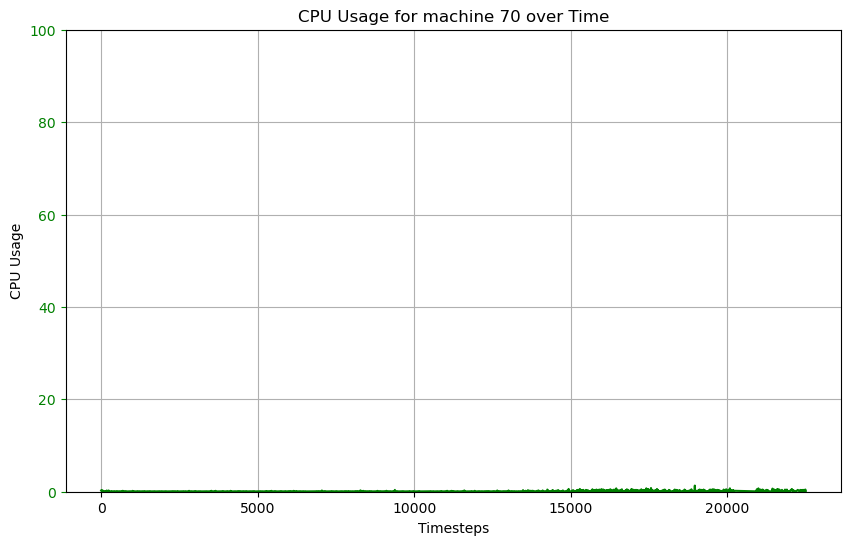

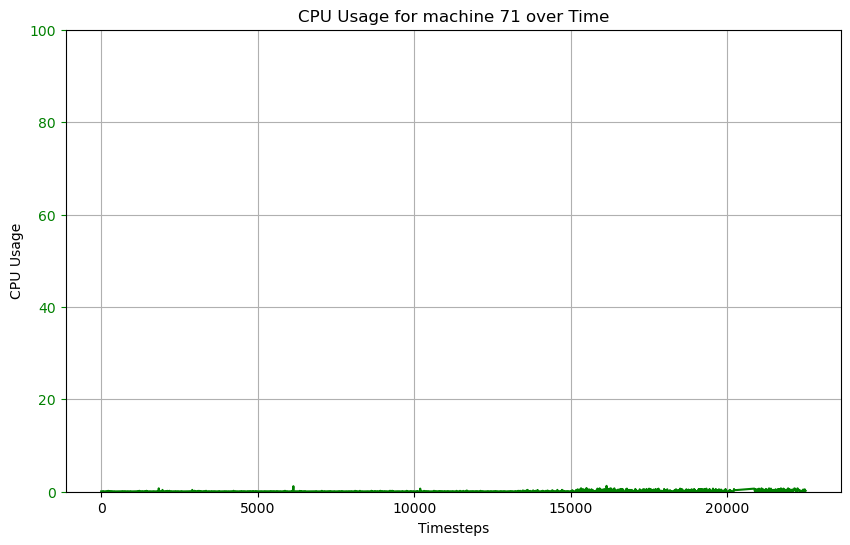

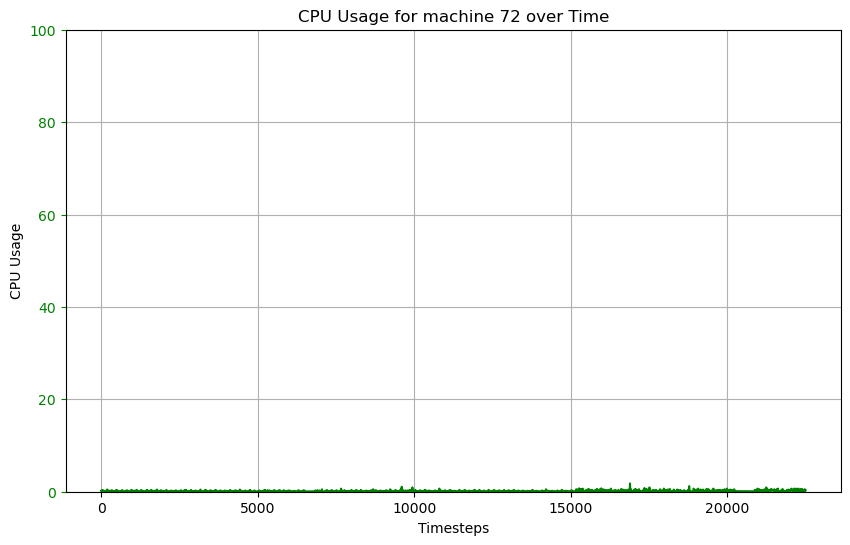

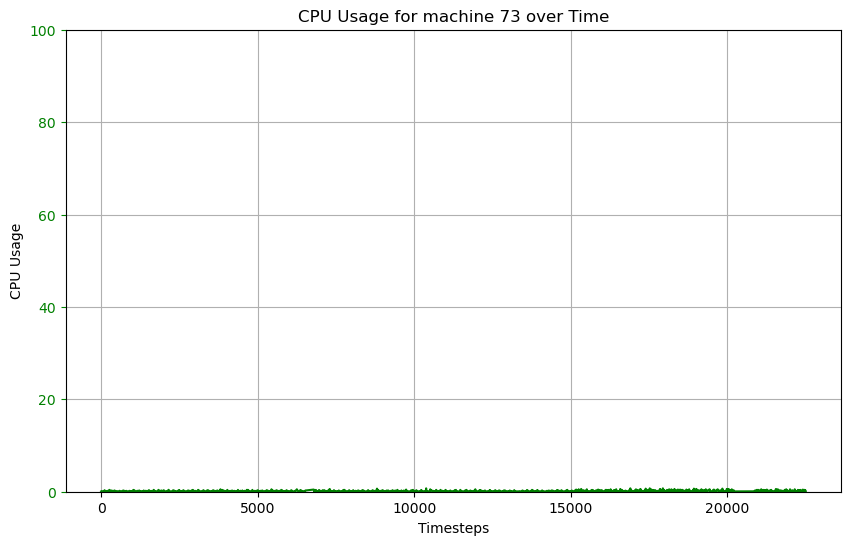

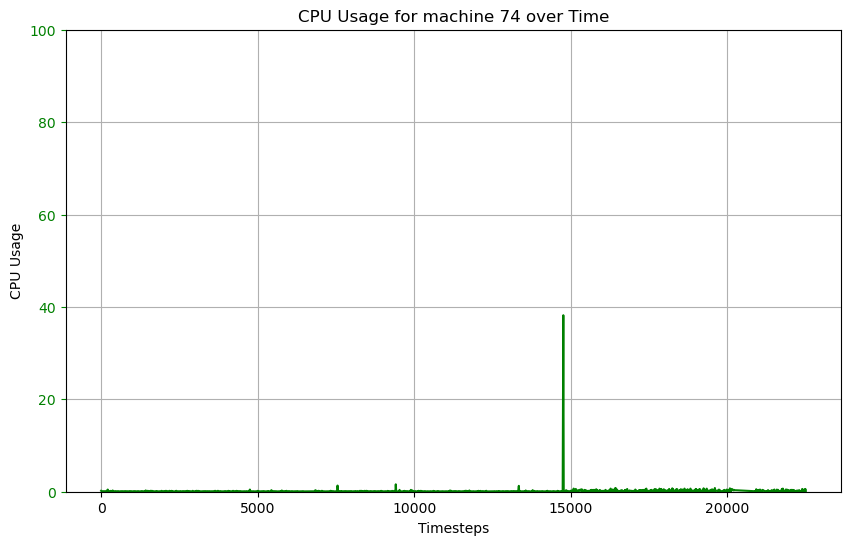

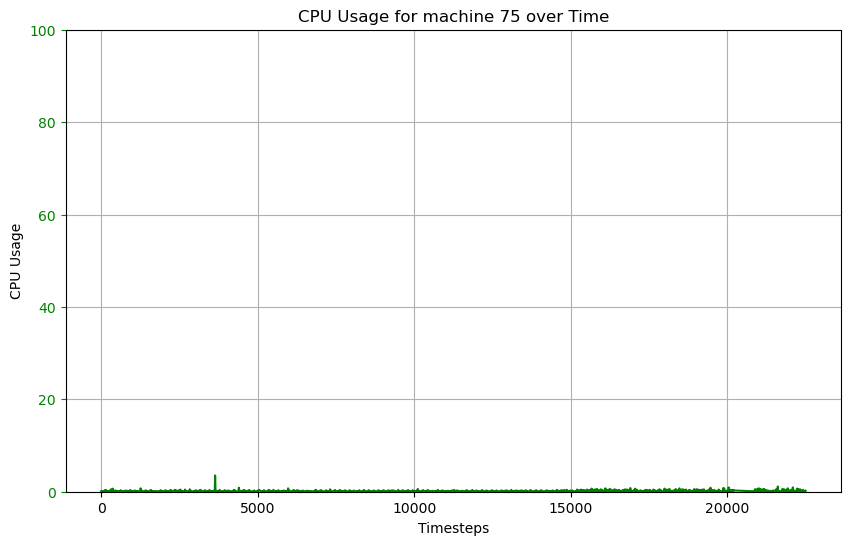

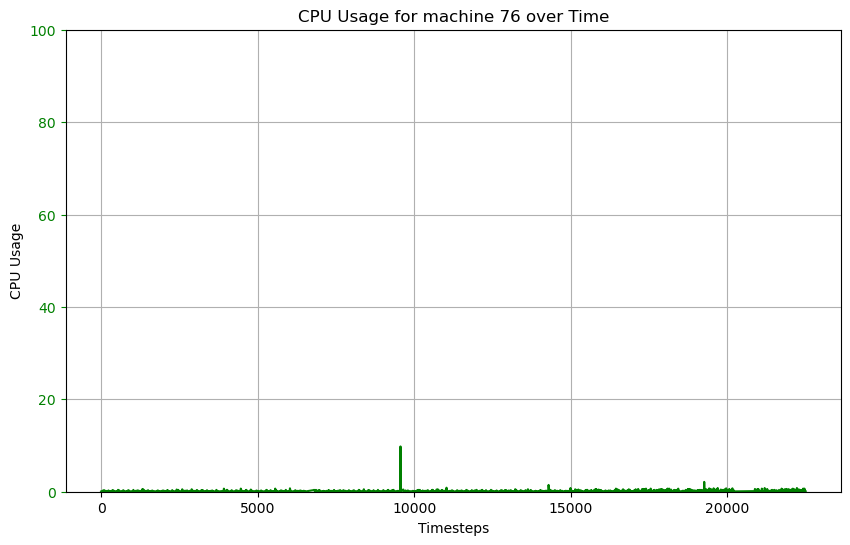

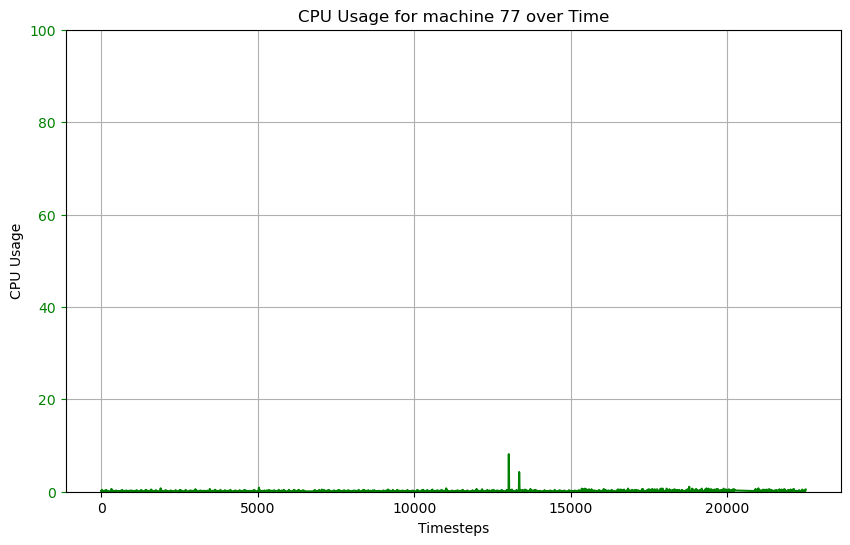

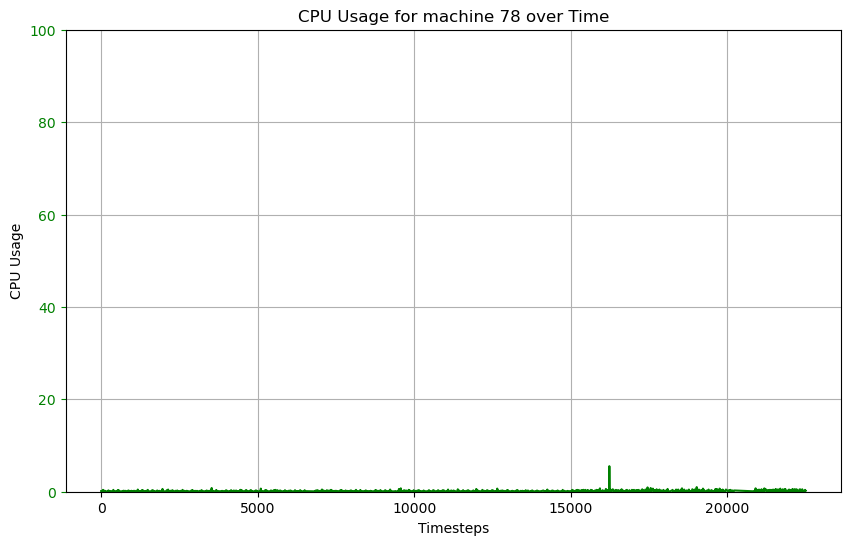

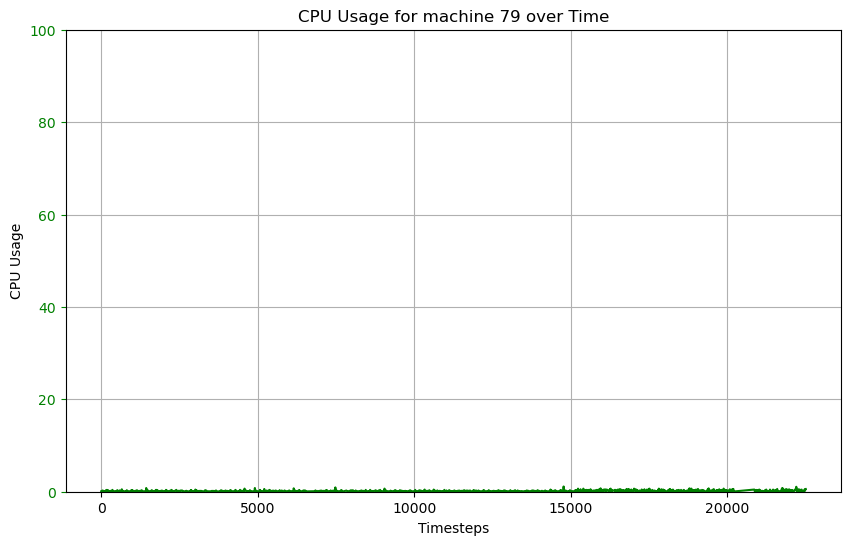

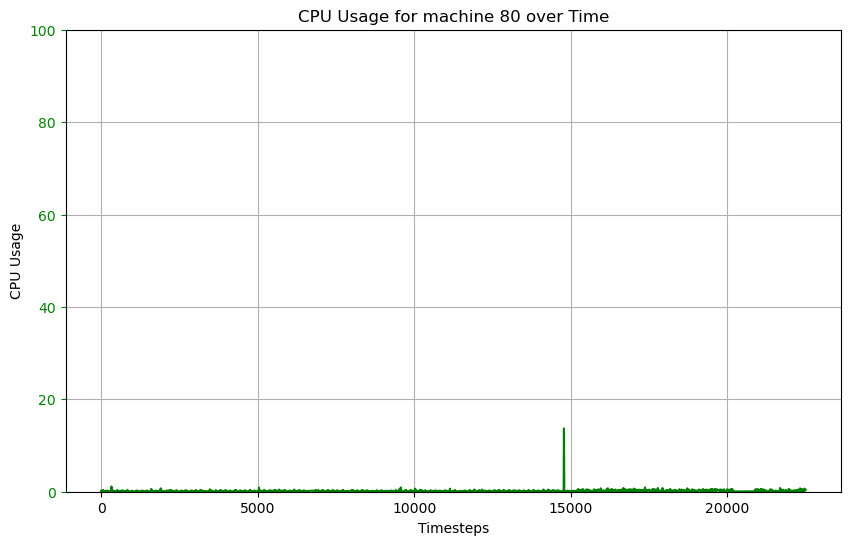

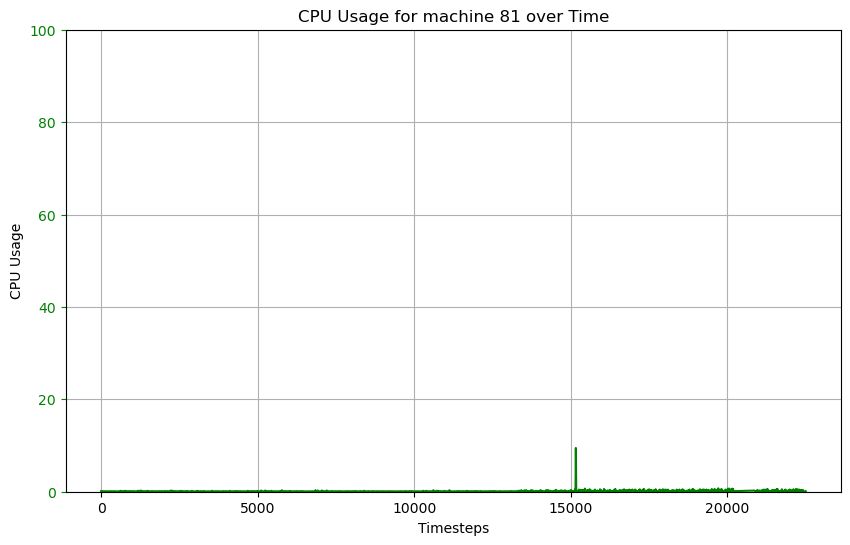

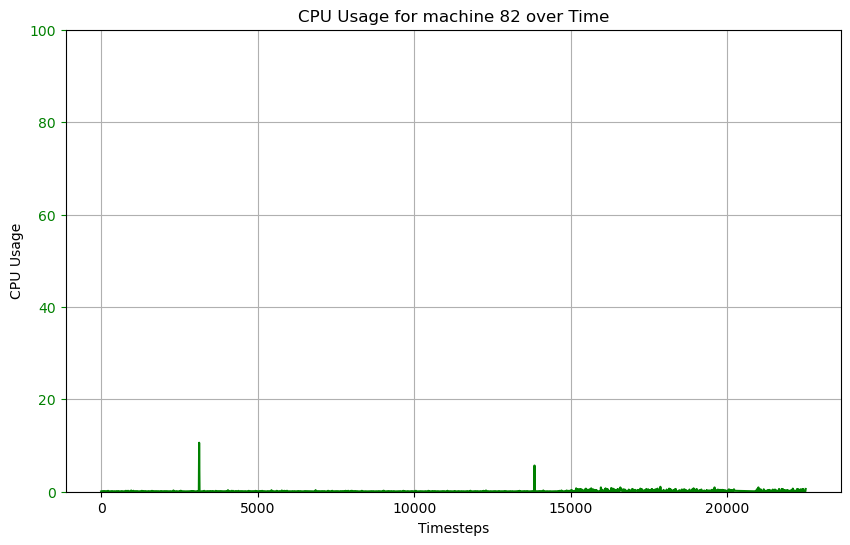

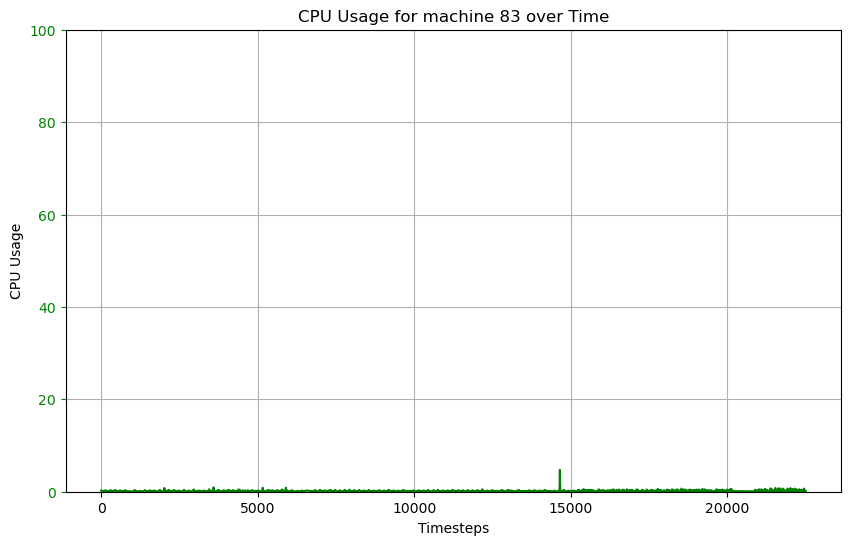

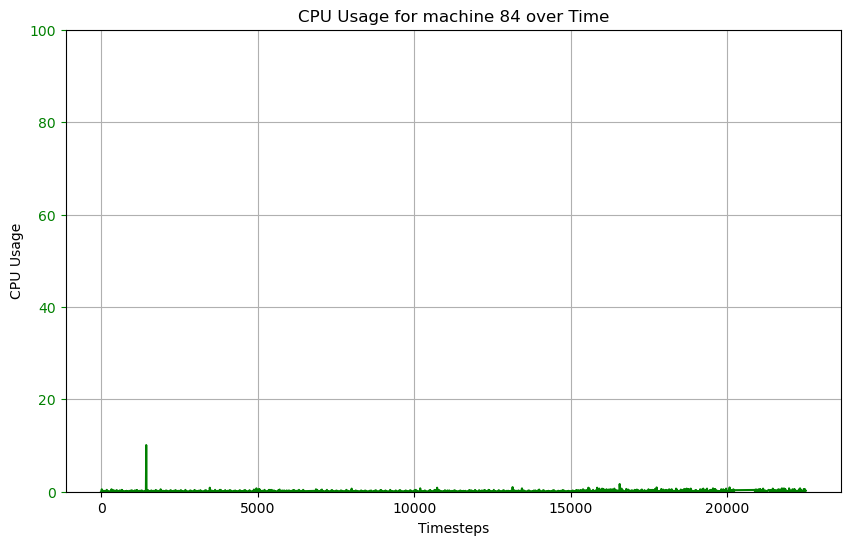

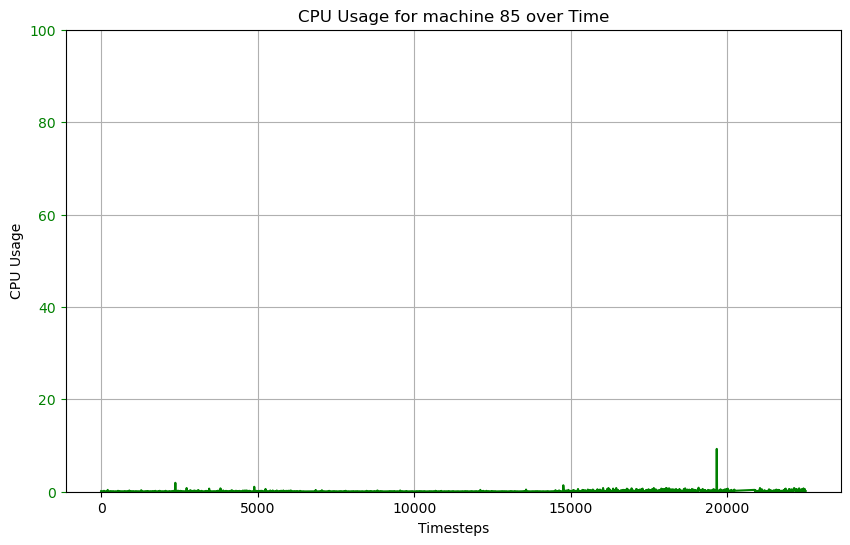

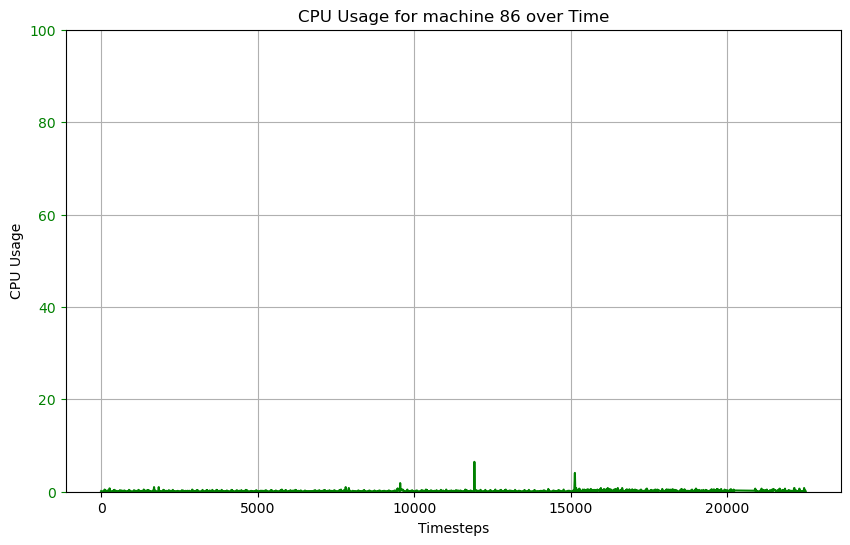

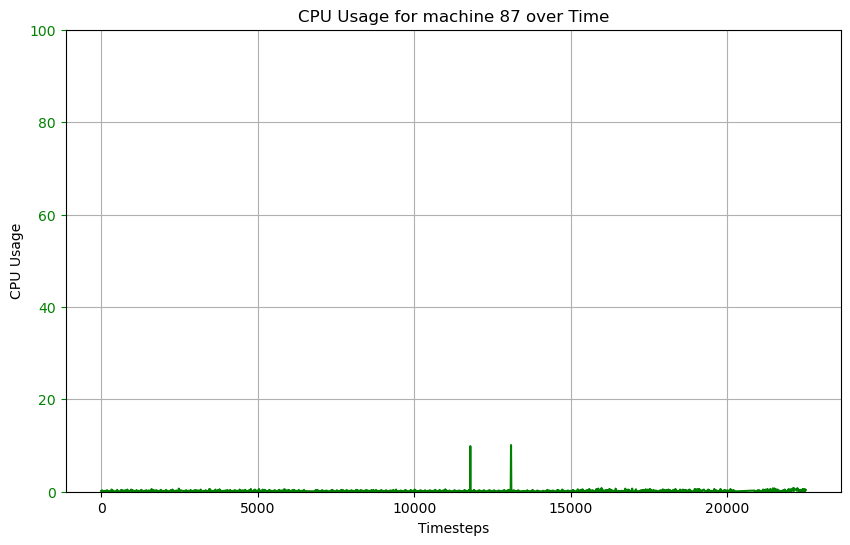

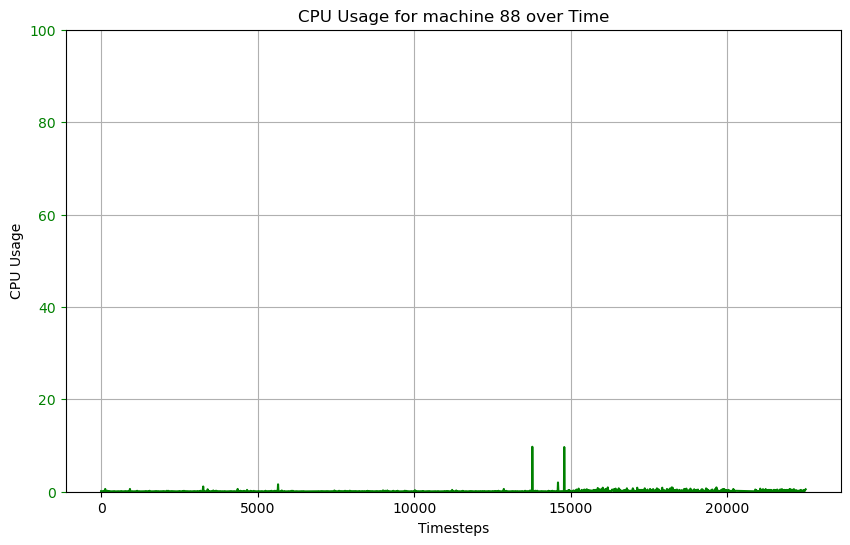

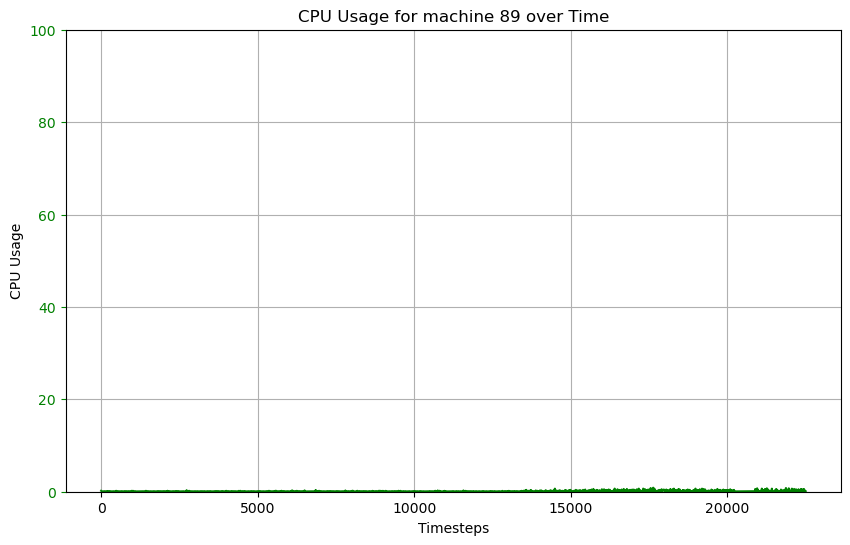

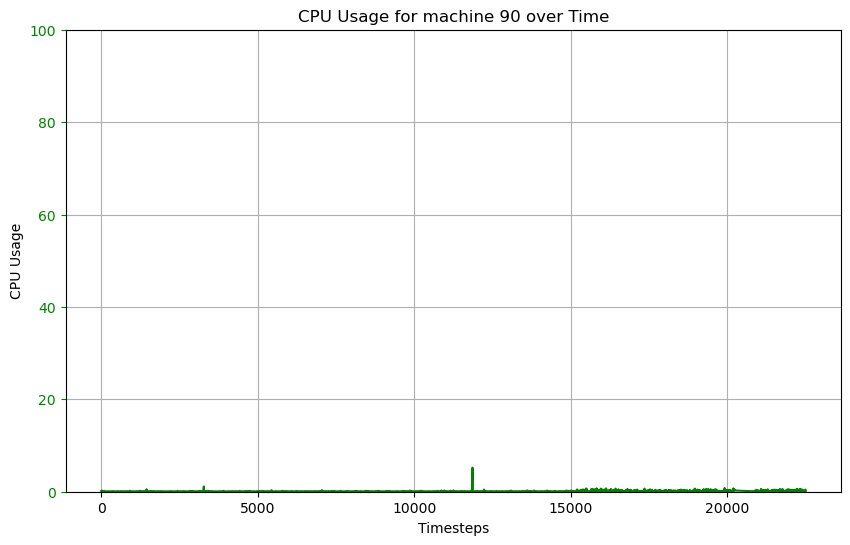

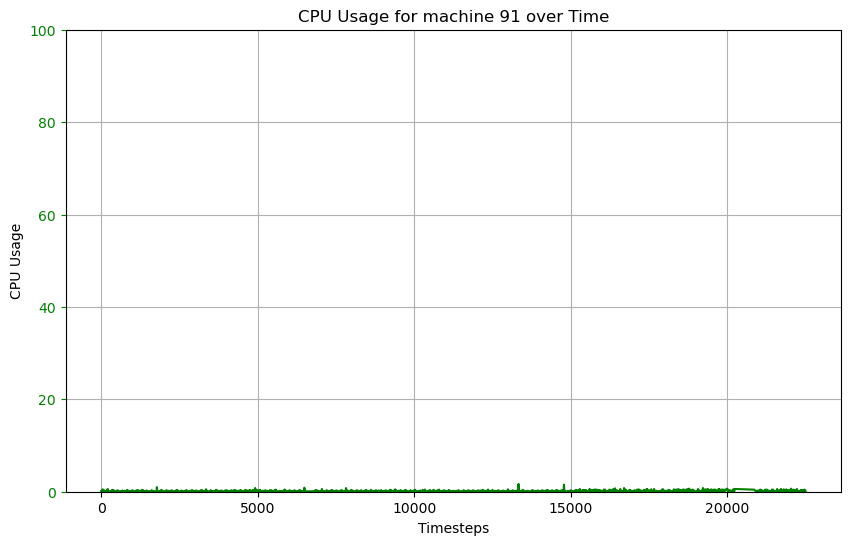

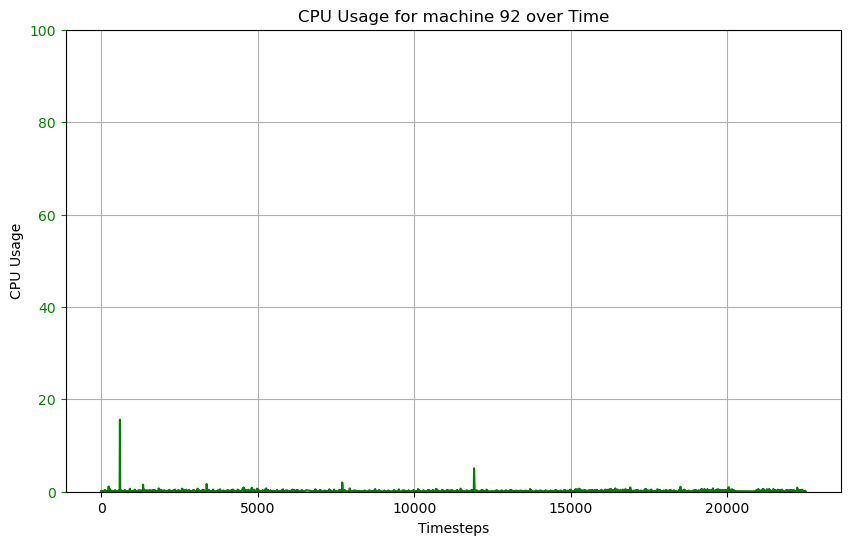

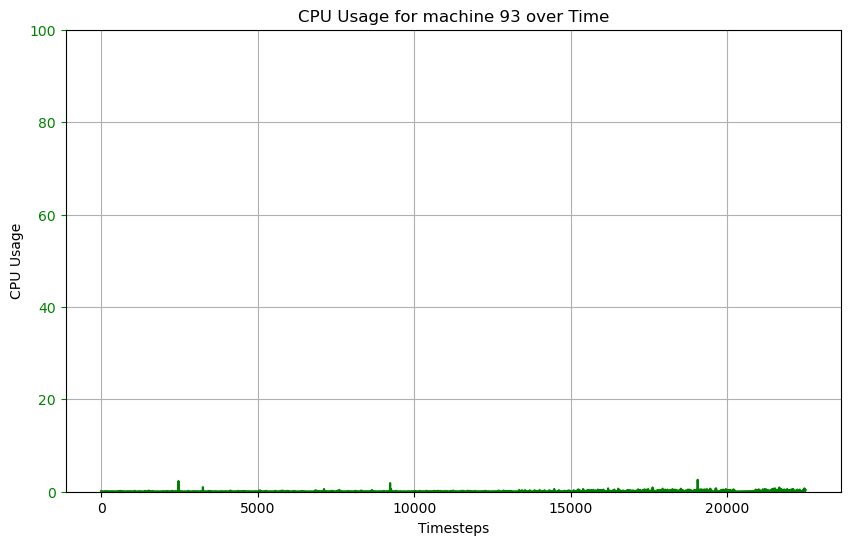

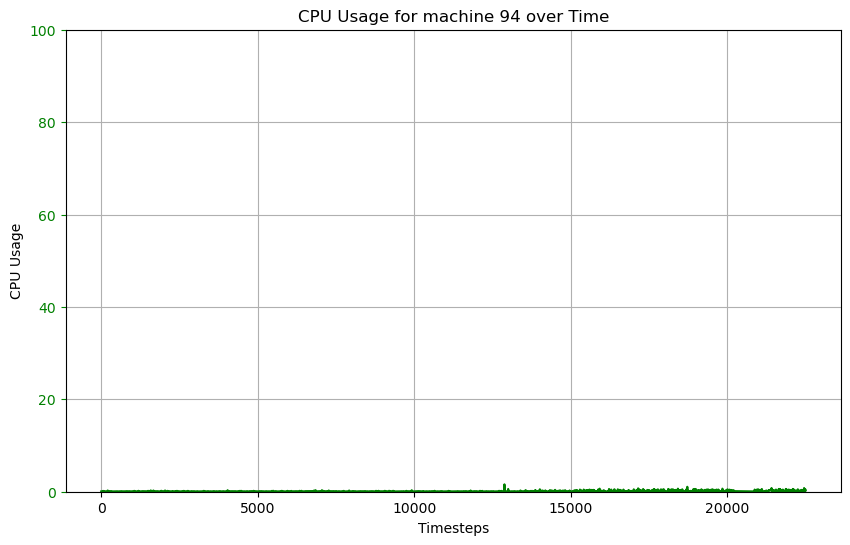

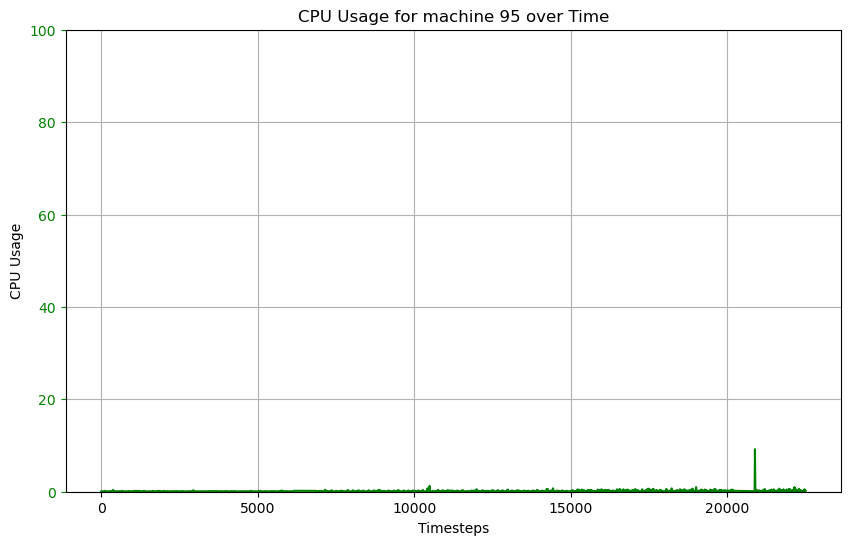

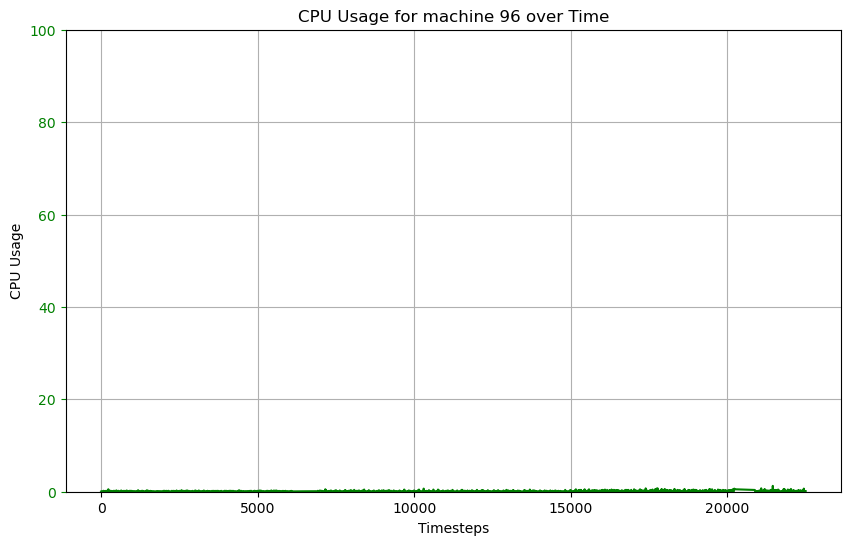

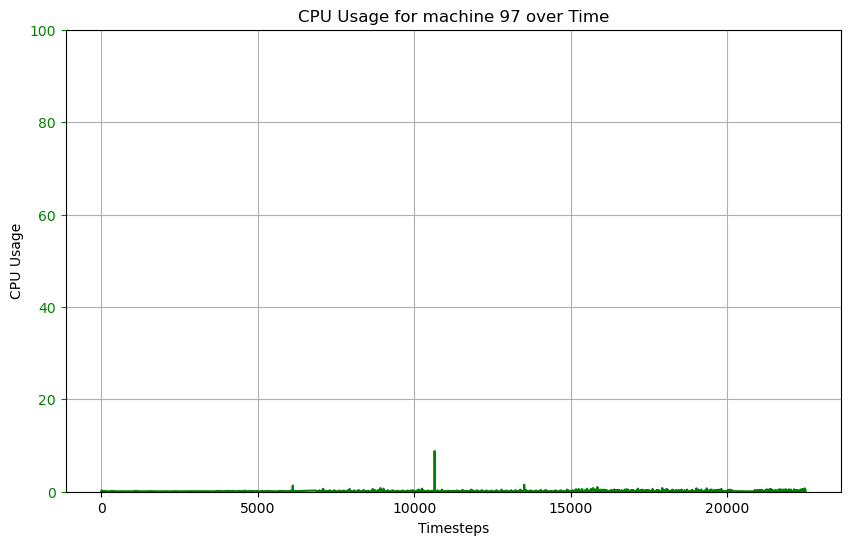

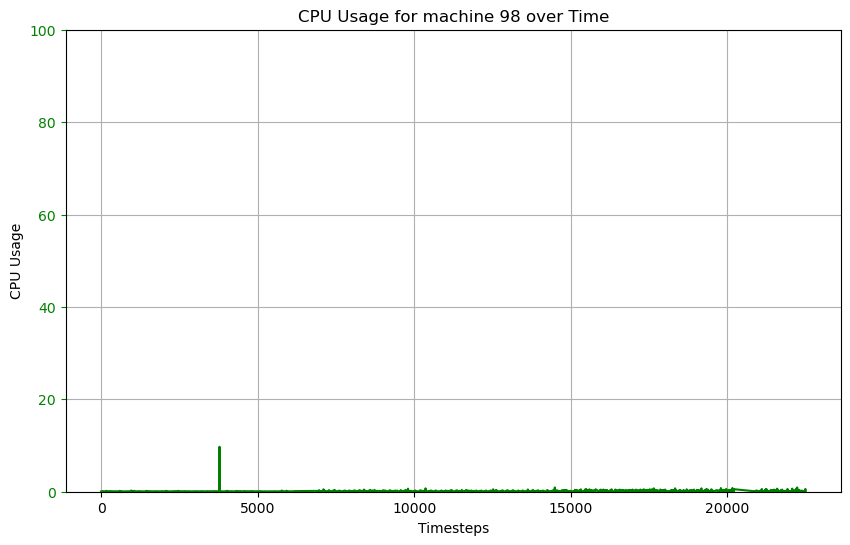

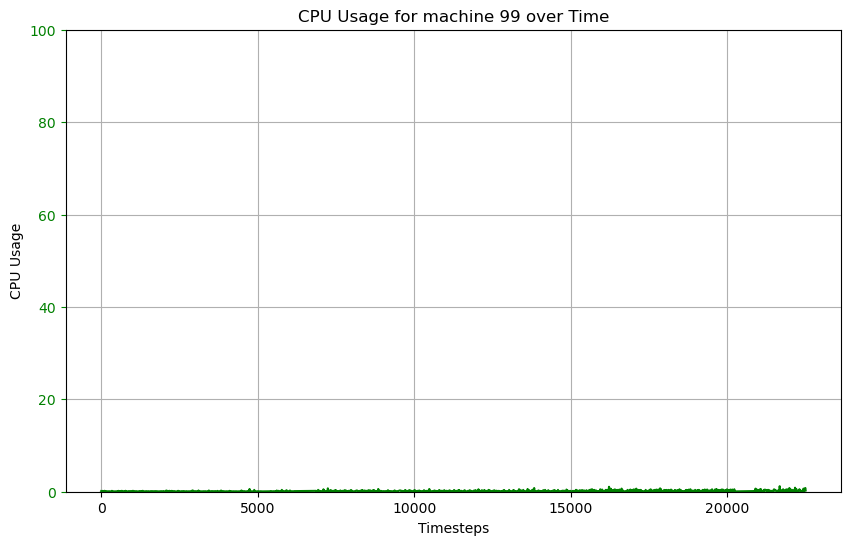

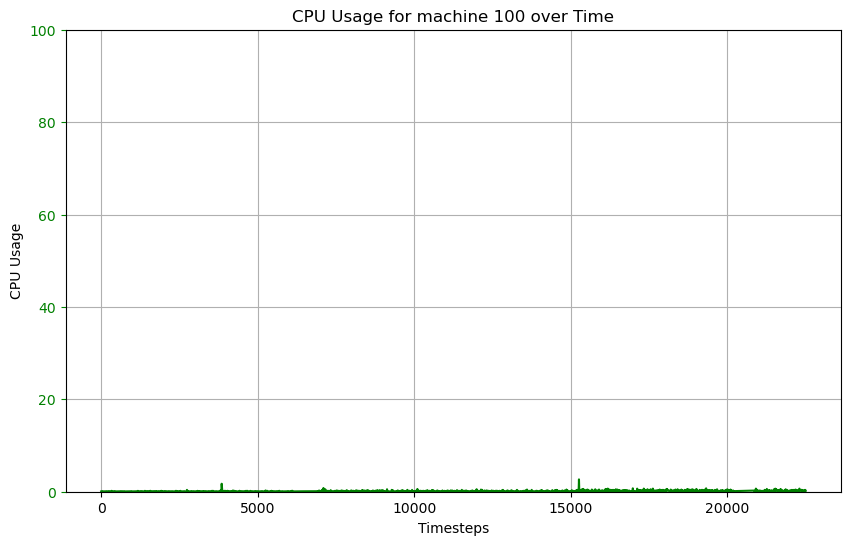

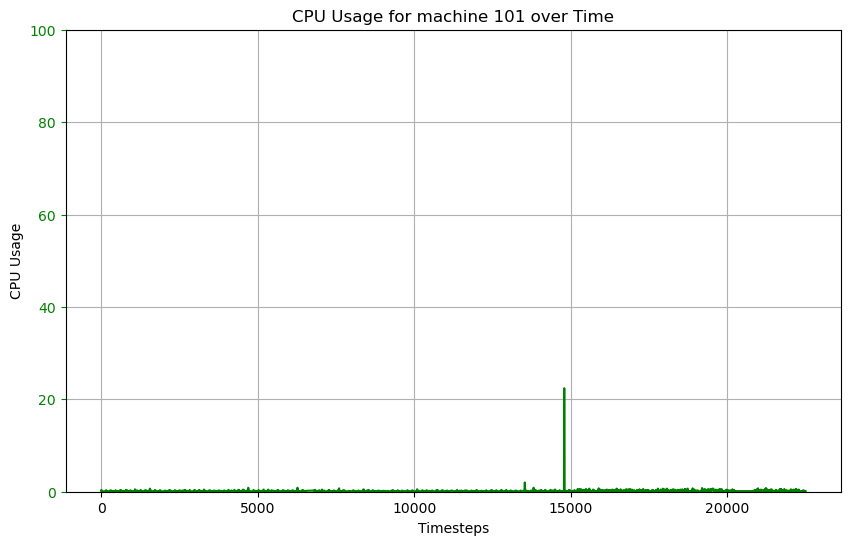

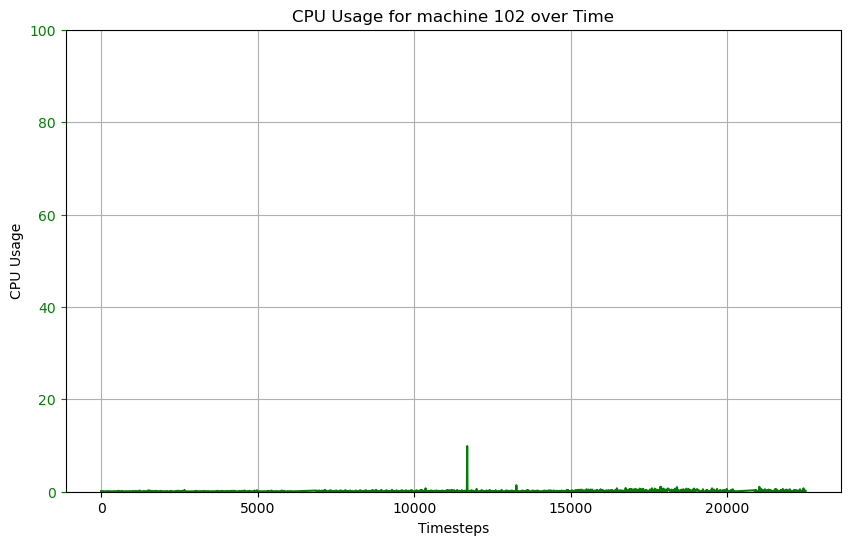

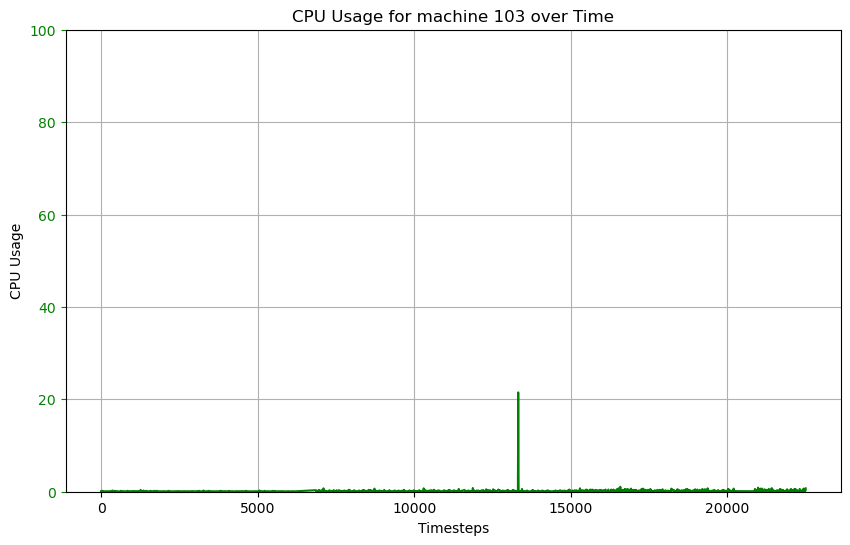

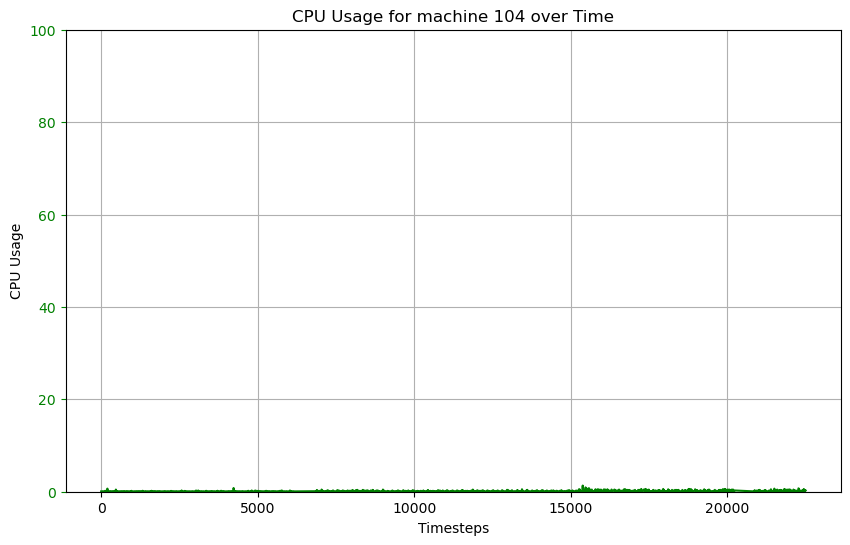

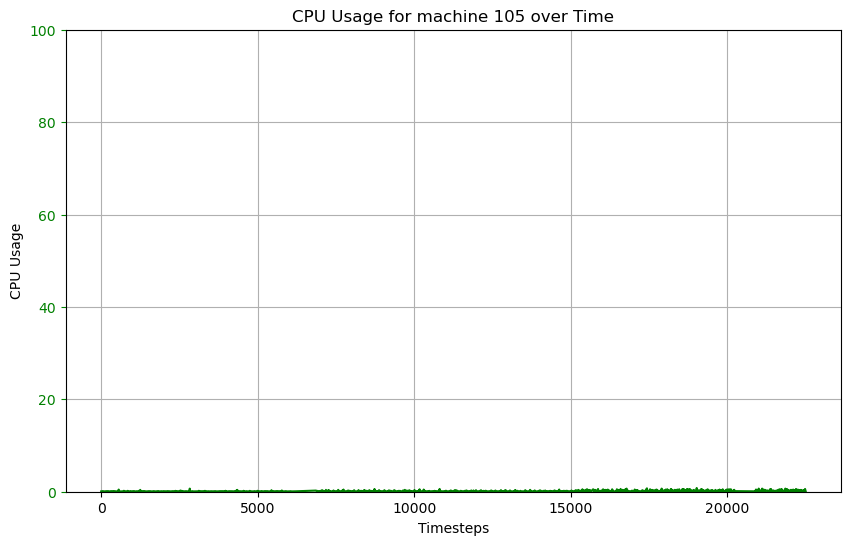

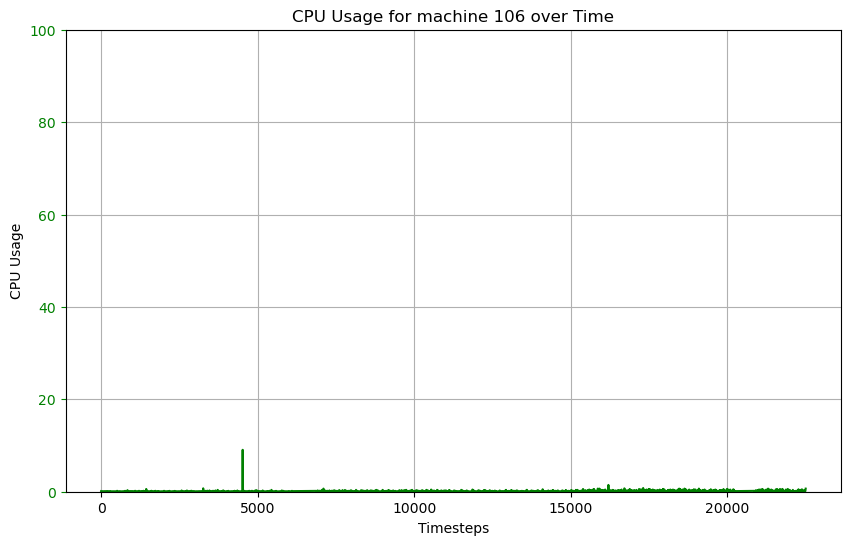

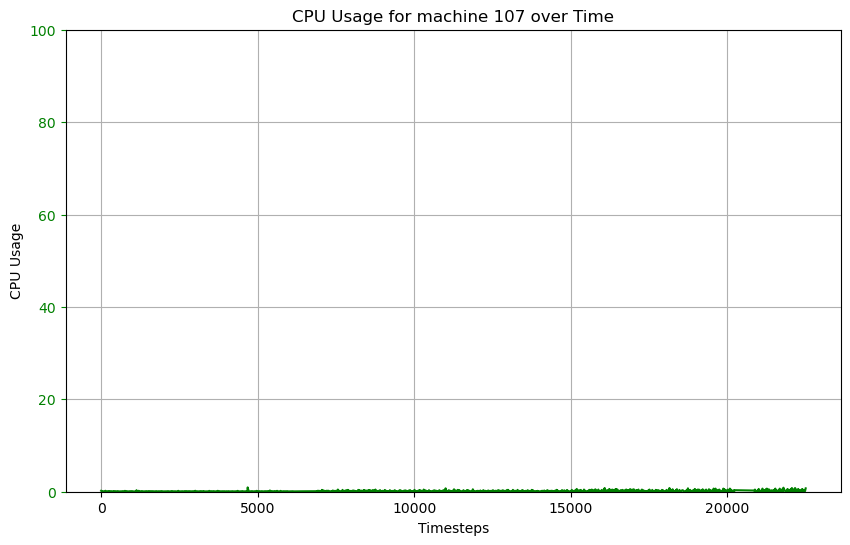

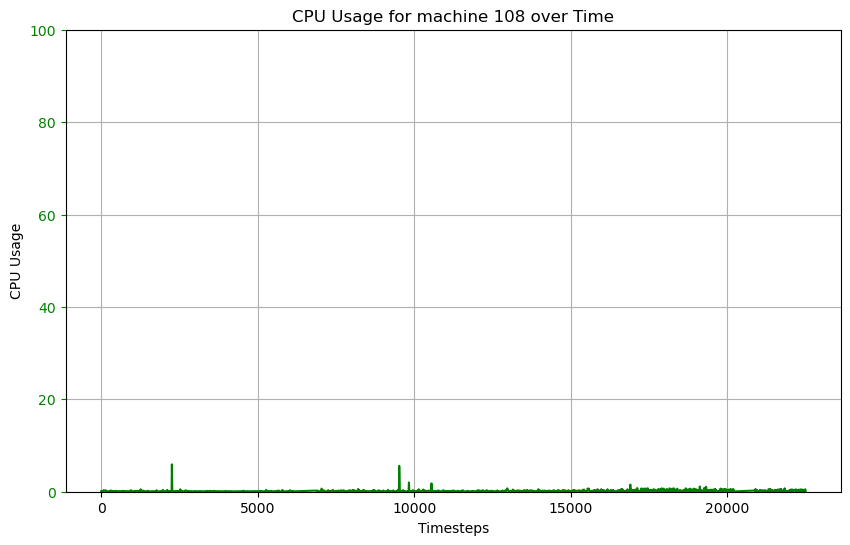

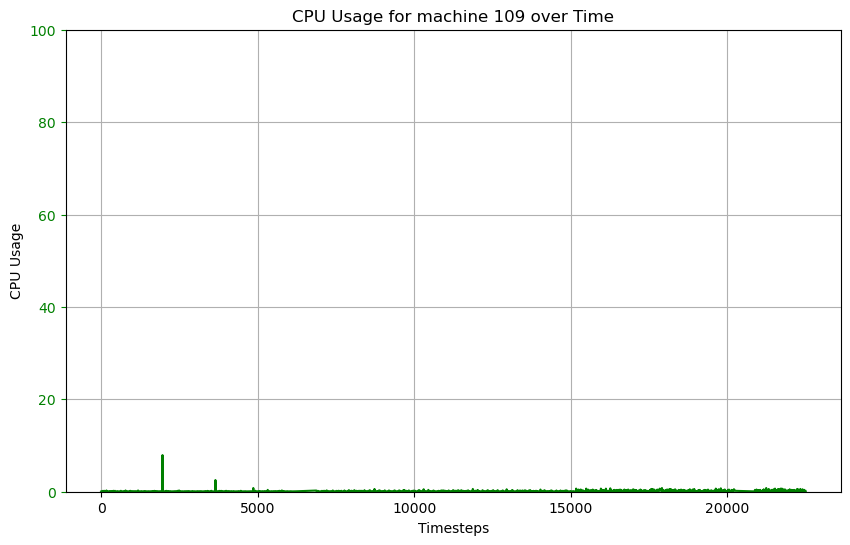

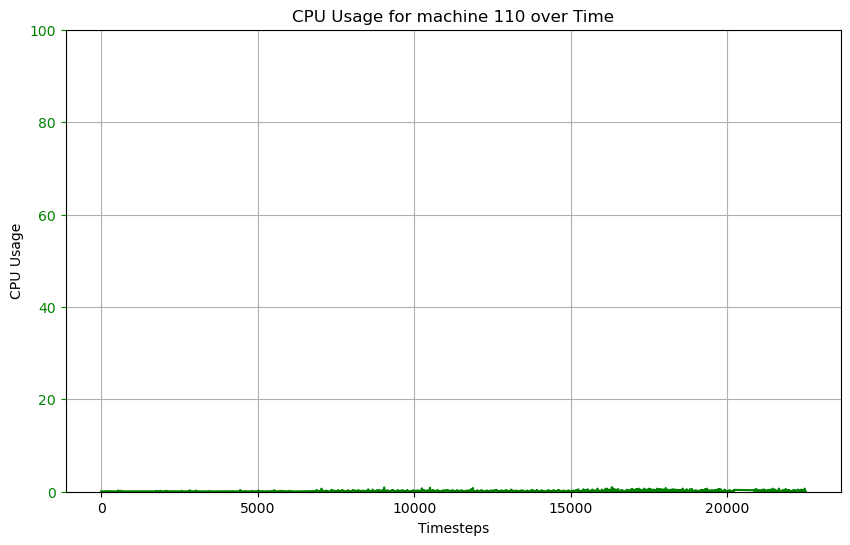

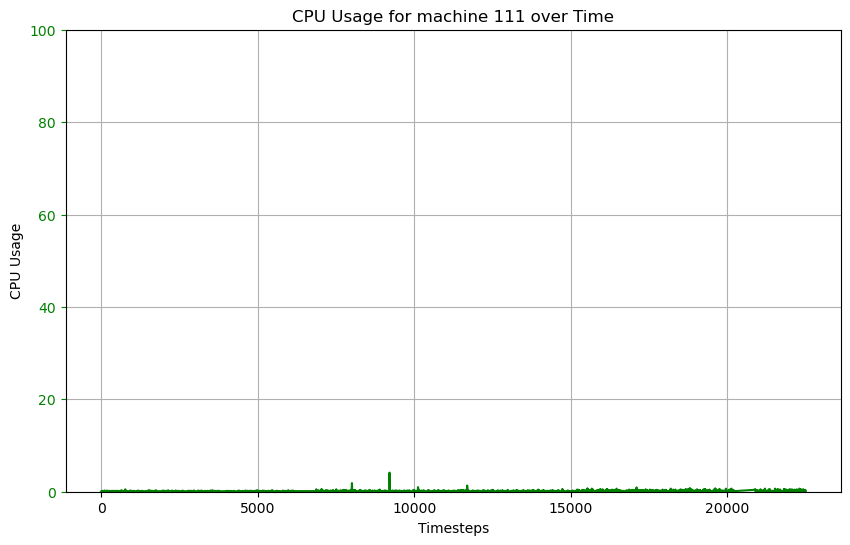

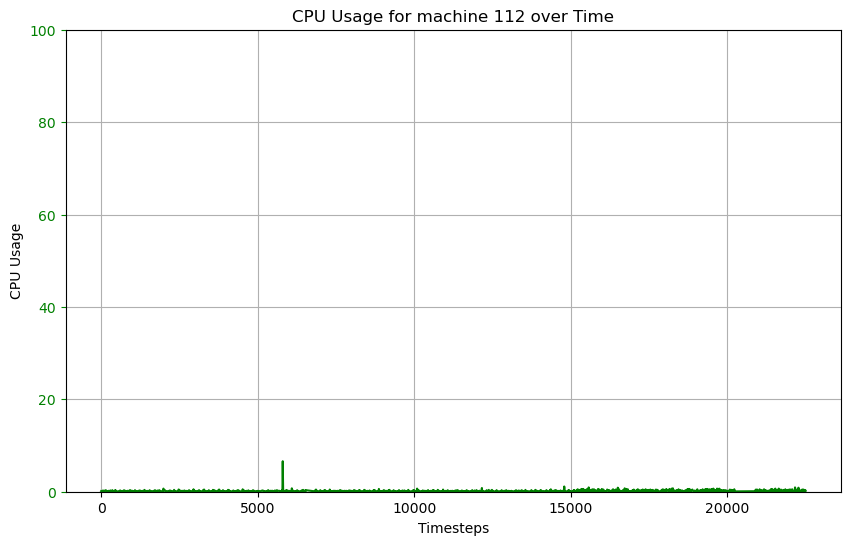

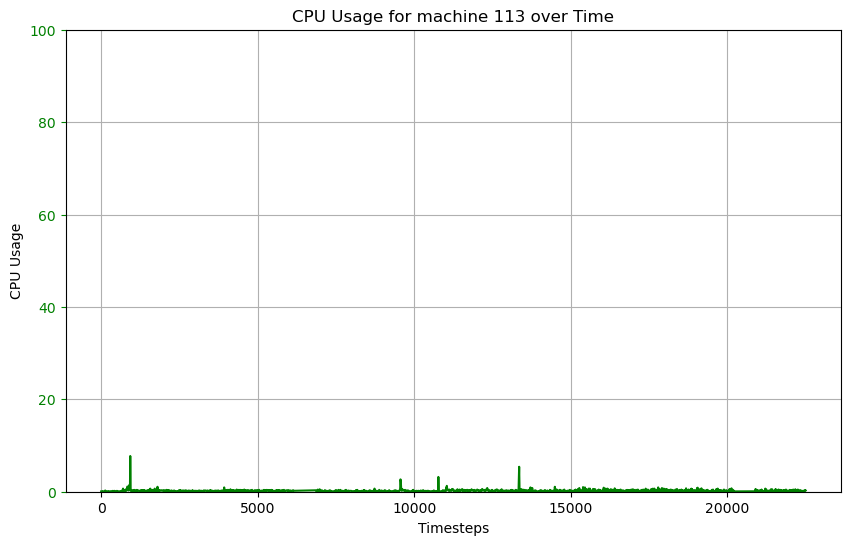

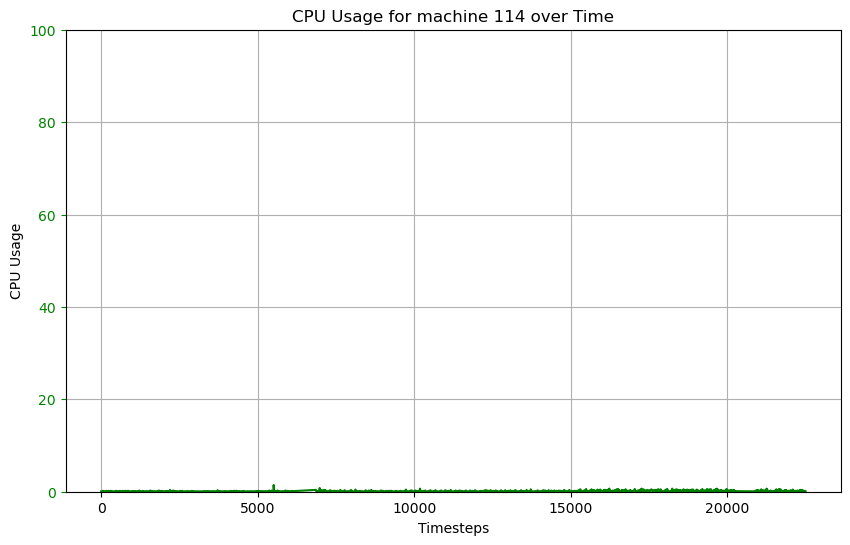

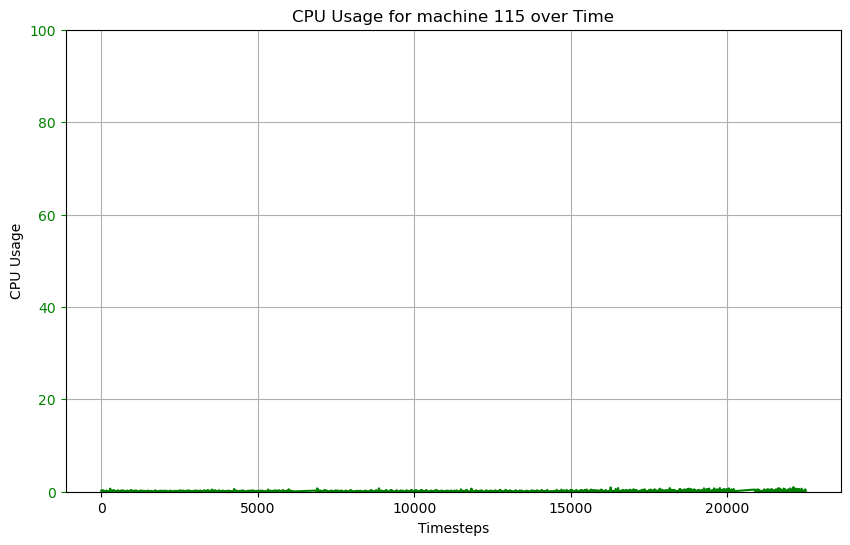

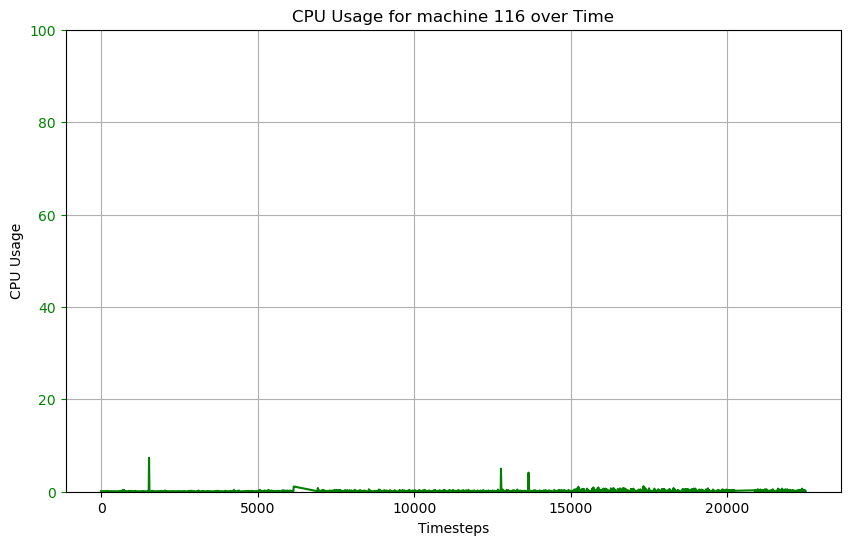

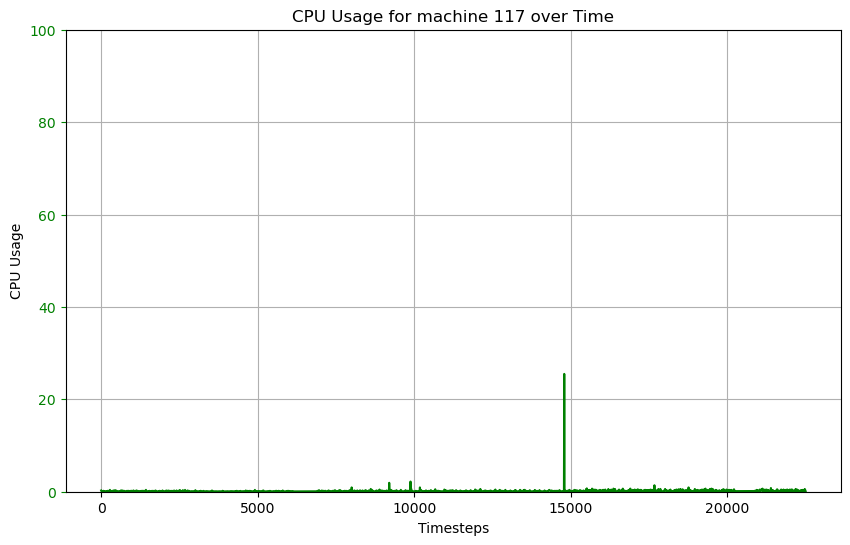

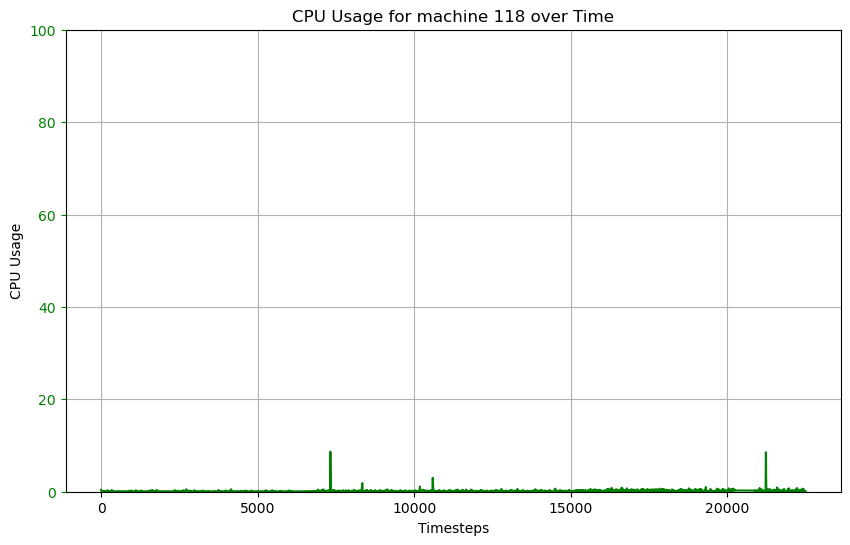

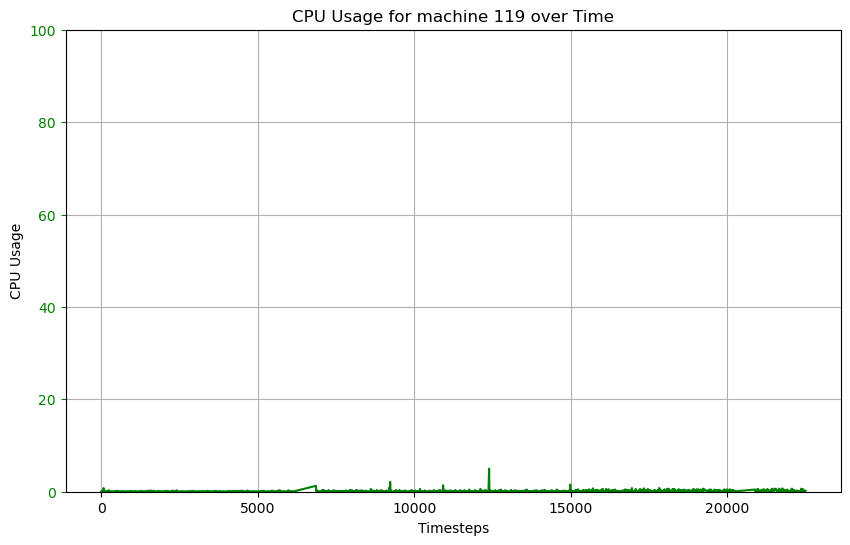

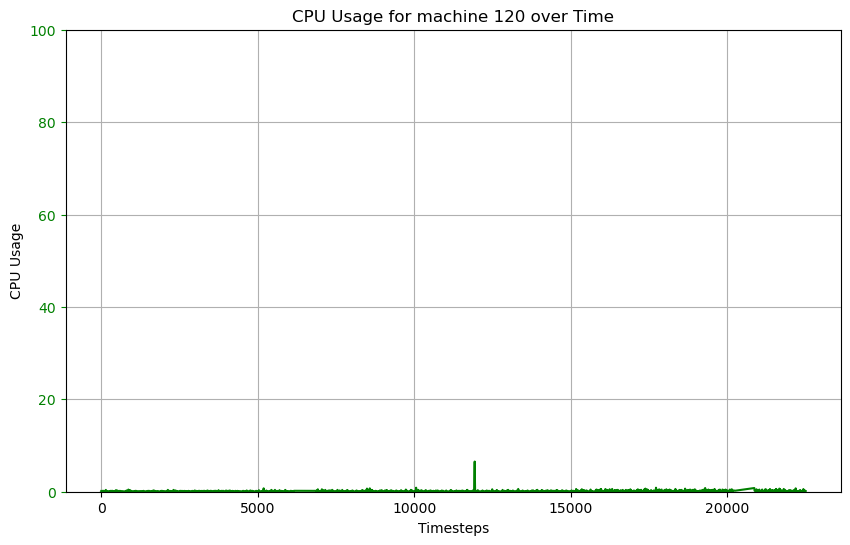

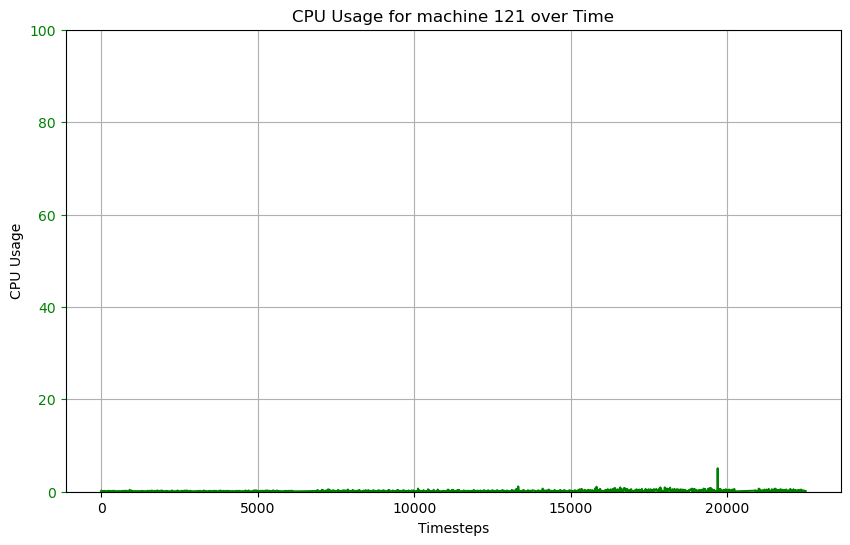

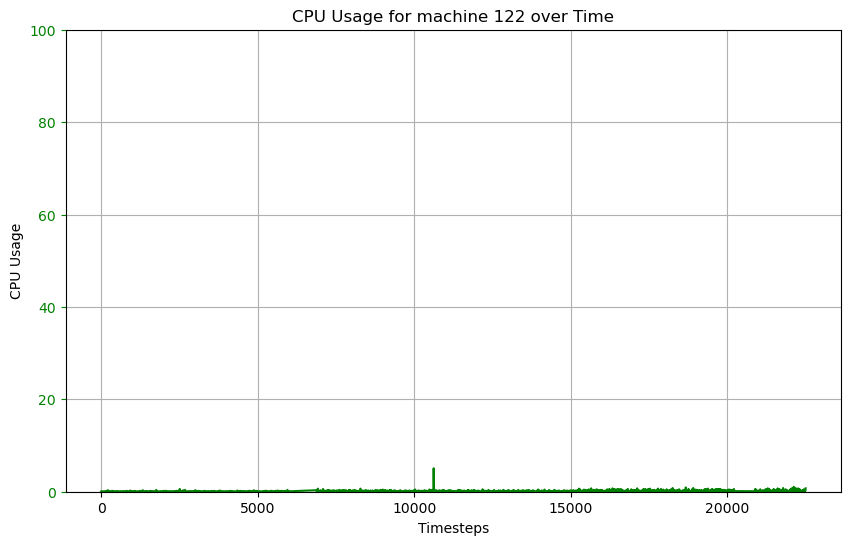

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

def convert_datetime_format(datetime_str):
    target_format = "%d/%m/%Y %H:%M"
    try:
        datetime_obj = parser.parse(datetime_str)
        return datetime_obj.strftime(target_format)
    except (ValueError, TypeError):
        print(f"Invalid datetime format: {datetime_str}")
        return None

def insert_missing_minutes(group):
    group = group.sort_values(by='datetime').reset_index(drop=True)
    all_rows = []
    for i in range(len(group) - 1):
        curr_time = group.iloc[i]['datetime']
        next_time = group.iloc[i + 1]['datetime']
        while next_time - curr_time > pd.Timedelta(minutes=1):
            curr_time = curr_time + pd.Timedelta(minutes=1)
            # Insert a new row for the missing minute with NaN for 'value'
            new_row = pd.DataFrame({
                'datetime': [curr_time],
                'machine_id': [group.iloc[i]['machine_id']],
                'cpu_usage': [np.nan]
            })
            all_rows.append(new_row)
    if all_rows:
        group = pd.concat([group] + all_rows).sort_values(by='datetime').reset_index(drop=True)
    return group

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    except:
        df['datetime'] = df['datetime'].apply(convert_datetime_format)
    df['cpu_usage'].replace(0, np.nan, inplace=True)
    if 'machine_id' in df.columns:
        df['machine_id'] = df['machine_id'].fillna(method='bfill')
        df['machine_id'] = pd.Categorical(df['machine_id']).codes + 1
    else:
        df['machine_id'] = 1
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    df = df.groupby('machine_id', group_keys=False).apply(insert_missing_minutes)
    df['cpu_usage'] = df.groupby('machine_id', group_keys=False)['cpu_usage'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    # Drop any rows with NaN values that were created due to shifting
    df.dropna(inplace=True)
    column_to_move = df.pop('cpu_usage')
    df.insert(1, 'cpu_usage', column_to_move)
    df = create_time_features(df)
    all_features_no_timestamp = df.columns[1:len(df.columns)]
    features_for_hmm = df[all_features_no_timestamp].values

    num_states = 10
    model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

    model.fit(features_for_hmm)

    for i, row in enumerate(model.transmat_):
        if row.sum() == 0:
            model.transmat_[i] = np.full(model.n_components, 1 / model.n_components)

    hidden_states = model.predict(features_for_hmm)

    df['hidden_state'] = hidden_states
    return df

cpu_data = pd.read_csv('../Utilities\csv/cpu_usage_university.csv')
columns_to_keep = ['datetime']
cpu_data = cpu_data.melt(id_vars=columns_to_keep, var_name='machine_id', value_name='cpu_usage')
cpu_data['cpu_usage'] = cpu_data['cpu_usage'].apply(lambda x: x * 100)
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)

file_path = "../Utilities/csv/cpu_usage_university_formatted.csv"
cpu_data.to_csv(file_path, index=False)

for machine_id, machine_data in cpu_data.groupby('machine_id'):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax.tick_params('y', colors='g')
    plt.xlabel('Timesteps')
    plt.ylabel('CPU Usage')
    ax.set_ylim(0, 100)
    plt.title(f'CPU Usage for machine {machine_id} over Time')
    plt.grid(True)
    plt.show()